# EZ: Analysis

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob as glob
import pdf_ccdf
import tqdm
import h5py
import sys
sys.path.append('/home/santiago_b/ez_model/src/')
import model as ez

In [4]:
import scipy.special as spec

In [5]:
def GammaDist(xplt,mean,var):
    theta = var/mean
    k = mean/theta #= mean**2/var
    return theta**(-k)*xplt**(k-1)*np.exp(-xplt/theta) / spec.gamma(k)

def NB(xplt,mean,var):
    p = (var-mean)/(var)
    r = mean**2/(var-mean)
    
    return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r

def Poisson(xplt,mean):
    
    return mean**xplt*np.exp(-mean)/spec.factorial(xplt,exact=True)

def GaussDist(xplt,mean,var):
    return (2*np.pi*var)**(-0.5)*np.exp(-(xplt-mean)**2/var/2)

In [6]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.serif"] = "Times New Roman"

In [7]:
# Threshold
def onoff_dist(T,dt,thresh):
    wt = []
    t_off = dt
    for q in T:
        if (q<=thresh):
            t_off += dt
        else:
            wt.append(t_off)
            t_off = dt

    return np.array(wt)

In [8]:
# Choose output directory
odir = './Figures/'

In [9]:
idirs = sorted(glob.glob('../*x*_f'))

In [10]:
excl = [
#     '../128x128_f',
#     '../1024x1024_f',
]

for run in excl:
    idirs.remove(run)

In [11]:
idirs

['../1024x1024_f', '../128x128_f', '../256x256_f', '../512x512_f']

## List of $c_0$ values

In [12]:
c0s = []
for idir in idirs:
    dirs = sorted(glob.glob(idir+'/c_0*'))
    
    runs = []
    for file in dirs:
        run = file.split('/')[2]
        runs.append(run)
        
        # Sort run-names based on value of c_0
        runs = sorted(runs, key=lambda x: float(x.split('_')[2].replace('d','.')), reverse=False)

#         print("Runs = {}".format(runs))

        c0s = [float(x.split('_')[2].replace('d','.')) for x in runs]
#         print("c0s = {}".format(c0s))
c0s = np.unique(np.array(c0s))
print(c0s)

[0.1       0.1133333 0.1266667 0.14      0.15      0.1533333 0.1566667
 0.16      0.1633333 0.1666667 0.17      0.1733333 0.1766667 0.18
 0.1833333 0.1866667 0.19      0.1933333 0.1966667 0.2       0.2066667
 0.22      0.2333333 0.2466667 0.26      0.2733333 0.2866667 0.3      ]


In [13]:
for run in runs[:1]:
    fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
    f = h5py.File(fname,'r')
    print(run)
    for subdat in f:
        print(subdat)
        print(f[subdat].keys())
#         print(subdat['tasks'].keys())
#         print(subdat['scales']['sim_time'][:])
    f.close()

c_0_1d000000e-01
parameters
<KeysViewHDF5 ['Nx', 'Ny', 'c_0', 'f', 'rho', 'skipmax', 'u_p']>
scalars
<KeysViewHDF5 ['bed_activity', 'e_last', 'e_mid', 'q_mid', 'time', 'tstep']>


In [14]:
# Scale for coloring:
def cscale_qins(q_in,q_ins_Ny):
    maxt = (np.max(q_ins_Ny))
    mint = (np.min(q_ins_Ny))
    return ((q_in) - mint)/(maxt-mint)

In [15]:
# Scale for coloring:
def cscale_crit(c,cs,c_c):
    maxt = np.max((np.max(cs)-c_c,np.abs(np.min(cs)-c_c)))
    return np.min((1,(c -np.min(cs))/(c_c -np.min(cs))/2))

# Time series

$$ q^*_{in} = \frac{q_{in}}{\tilde{\Delta t}_{s}} \frac{4}{3} \pi \frac{1}{\tilde{b}} \left(\frac{\rho_w}{\rho_s - \rho_w}\right)^{1/2}$$

## Bed slopes

In [12]:
plot_yn = False

In [13]:
# params = {'Nx':self.Nx,'Ny':self.Ny,'c_0':self.c_0,'f':self.f,'skipmax':self.skipmax,'u_p':self.u_p,'rho':self.rho,'q_in':self.q_in}
# odata = ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
# Nx,Ny,c_0,f,skipmax,u_p,q_in,rho = 1.25,initial=0.0

In [14]:
slopes_bed = dict([])
c0s_d = dict([])
prob_d = dict([])
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    c0s_l = []
    prob_l = []
    
    dirs = sorted(glob.glob(idir+'/c_0*'))

#     runs = []
#     for file in dirs:
#         run = file.split('/')[2]
#         runs.append(run)

#     # Sort run-names based on value of c_0
#     runs = sorted(runs, key=lambda x: float(x.split('_')[2].replace('d','.')), reverse=False)

    for ii,run in enumerate(runs):
#         print("Working on %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        skipmax = file['parameters']['skipmax'][()]    
        file.close()

        # Initialize
        set_q = ez.set_f(Nx,Ny,c_0,f,skipmax,u_p)

        # Load data:
        set_q.load_data(str(glob.glob(idir+'/'+run+'/*_state.h5')[0]))
        set_q.e = np.copy(set_q.ep)
        set_q.plot_min()
#         for ii,cross in enumerate(set_q.z):
#             plt.plot(cross,color=(0,0,(ii+1)/len(set_q.z),1))

        # SLope
        z_avg = np.mean(set_q.z,axis=0)
        x = np.arange(len(z_avg))
        m,b = np.polyfit(x,z_avg,1)

#         # Average c_0
#         # Run for 1000 time steps
#         ne = 0
#         ptemp = np.zeros(set_q.e.shape)
#         N = 500
#         for i in tqdm.tqdm(range(N)):
#             set_q.step()
#             ne += np.sum(set_q.e)/N
#             ptemp += set_q.p_calc()/N
#         prob_l.append(np.mean(ptemp)*Nx*Ny/ne)
        
        s=np.diff(set_q.z,axis=1).flatten()
#         d = np.diff(np.unique(s)).min()
#         left_of_first_bin = s.min() - float(d)/2
#         right_of_last_bin = s.max() + float(d)/2
#         plt.hist(s, np.arange(left_of_first_bin, right_of_last_bin + d, d),
#                  log=False,density=True,color=cm.brg(cscale_crit(c_0,c0s,0.37)),histtype='step')
        cs = c_0*np.sqrt(1+s**2)
        cs[s>0]=0
        prob_l.append(np.mean(cs))
        
        slopes_l.append(m)
        c0s_l.append(c_0)    
#         plt.xlim(-15,15)
#         plt.show()
        
    slopes_bed['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
    c0s_d['%sx%s' % (Nx,Ny)] = np.array(c0s_l)
    prob_d['%sx%s' % (Nx,Ny)] = np.array(prob_l) 
#     plt.xlim(-15,15)
#     plt.show()

Working on ../1024x1024_f


IndexError: list index out of range

In [ ]:
plt.figure(figsize=(8,6))
for dirr in slopes_bed:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
    plt.plot(c0s_d[dirr],prob_d[dirr],marker = 'o',c=cm.copper(np.sqrt(Ny/(512))),ls='',label = dirr)
cplt = np.linspace(np.min(c0s),np.max(c0s),1000)
plt.plot(cplt,np.ones(cplt.shape),'--r')
plt.legend(loc=(1.01,0.2))
# plt.xlabel("$q^*_{in}$")
plt.xlabel("$c_0$")
# plt.ylabel("Avg probability of \n entraining neighbor")
plt.ylabel("Avg $c$")
plt.show()

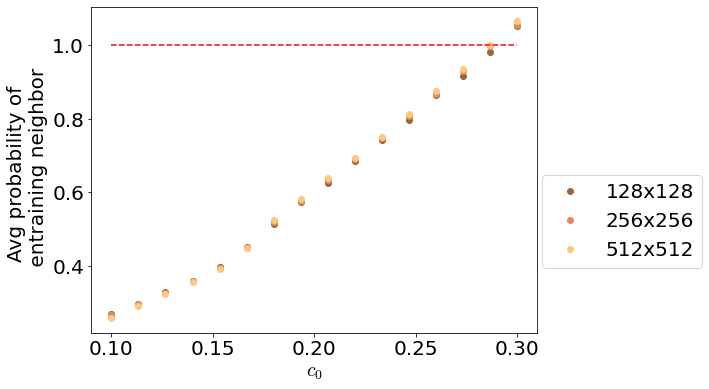

In [24]:
plt.figure(figsize=(8,6))
for dirr in slopes_bed:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
    plt.plot(c0s_d[dirr],prob_d[dirr],marker = 'o',c=cm.copper(np.sqrt(Ny/(512))),ls='',label = dirr)
cplt = np.linspace(np.min(c0s),np.max(c0s),1000)
plt.plot(cplt,np.ones(cplt.shape),'--r')
plt.legend(loc=(1.01,0.2))
# plt.xlabel("$q^*_{in}$")
plt.xlabel("$c_0$")
plt.ylabel("Avg probability of \n entraining neighbor")
# plt.ylabel("Avg $c$")
plt.show()

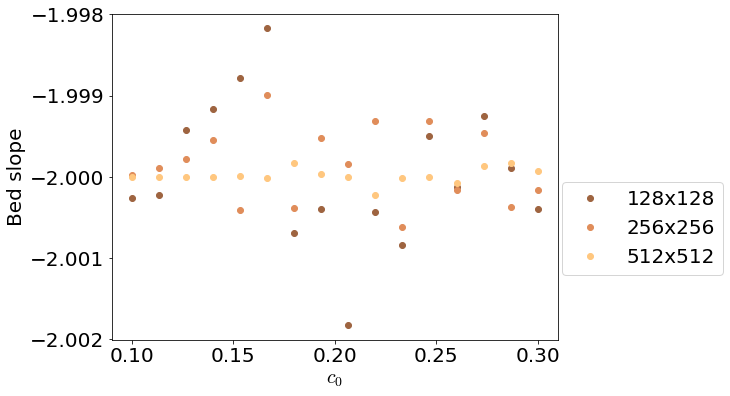

In [25]:
plt.figure(figsize=(8,6))
for dirr in slopes_bed:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
    plt.plot(c0s_d[dirr],slopes_bed[dirr],marker = 'o',c=cm.copper(np.sqrt(Ny/(512))),ls='',label = dirr)
plt.legend(loc=(1.01,0.2))
# plt.xlabel("$q^*_{in}$")
plt.xlabel("$c_0$")
plt.ylabel("Bed slope")
# plt.title("Measuring Bed Activity")
plt.show()

## Max values as a function of size

In [26]:
max_ba = dict([])
c0s_d = dict([])
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    c0s_l = []
    
    dirs = sorted(glob.glob(idir+'/c_0*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        runs.append(run)

    # Sort run-names based on value of c_0
    runs = sorted(runs, key=lambda x: float(x.split('_')[2].replace('d','.')), reverse=False)

    for ii,run in enumerate(runs):
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        skipmax = file['parameters']['skipmax'][()]    

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last']
        time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        bed_activity = file['scalars']['bed_activity'][()]
#         q_out = file['scalars']['e_last'][()]

        # Close file:
        file.close()

#         ba_max = np.max(q_out)
        ba_max = np.mean(np.sort(bed_activity)[-10:])
        
        slopes_l.append(ba_max)
        c0s_l.append(c_0)
        
    max_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
    c0s_d['%sx%s' % (Nx,Ny)] = np.array(c0s_l)


Working on ../128x128_f
Working on ../256x256_f
Working on ../512x512_f


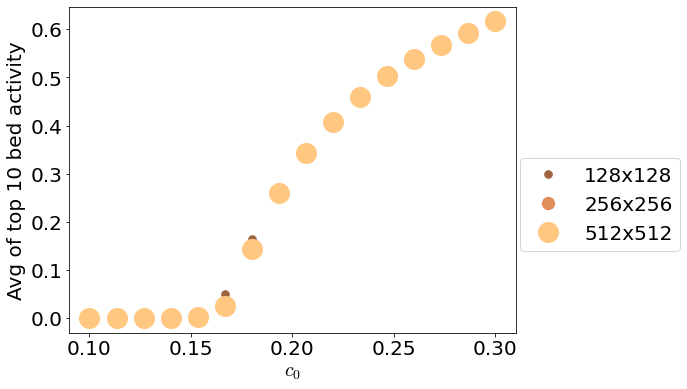

In [27]:
plt.figure(figsize=(8,6))
for dirr in max_ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.axhline(y=1,c='r',ls='--')
    plt.plot(c0s_d[dirr],max_ba[dirr],marker = 'o',c=cm.copper(np.sqrt(Ny/512)),ms=20*(Nx/512)**0.7,ls='',label = dirr)
# xplt = np.linspace(0,np.max(q_ins_Ny),1000)
# plt.plot(xplt,xplt,'-r',label='1:1')
plt.legend(loc=(1.01,0.25))
plt.xlabel("$c_0$")
# plt.xlabel("$q_{in}/N_y$")
# plt.ylabel(r"Max$(q_{out}/N_y)$")
plt.ylabel(r"Avg of top 10 bed activity")
# plt.title("Measuring Bed Activity")
plt.show()

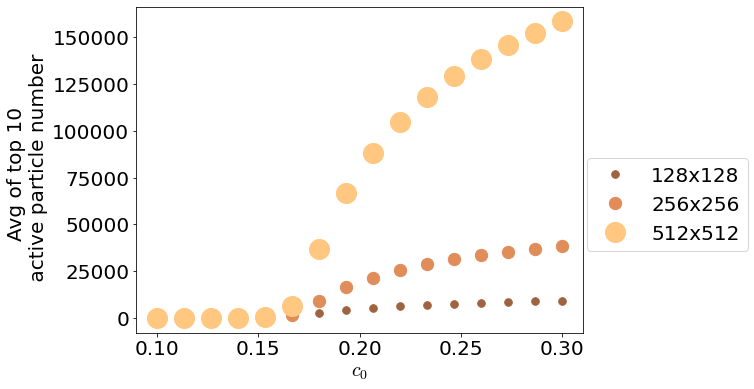

In [28]:
plt.figure(figsize=(8,6))
for dirr in max_ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.axhline(y=1,c='r',ls='--')
    plt.plot(c0s_d[dirr],max_ba[dirr]*(Nx-10)*Ny,marker = 'o',c=cm.copper(np.sqrt(Ny/512)),ms=20*(Nx/512)**0.7,ls='',label = dirr)
# xplt = np.linspace(0,np.max(q_ins_Ny),1000)
# plt.plot(xplt,xplt,'-r',label='1:1')
plt.legend(loc=(1.01,0.25))
plt.xlabel("$c_0$")
# plt.xlabel("$q_{in}/N_y$")
# plt.ylabel(r"Max$(q_{out}/N_y)$")
plt.ylabel("Avg of top 10 \n active particle number")
# plt.title("Measuring Bed Activity")
plt.show()

## Average mass flux and bed activity

In [15]:
ba = dict([])
qs = dict([])
c0s_d = dict([])
for idir in idirs:
    print("Working on %s" % idir)
    ba_l = []
    qs_l = []
    c0s_l = []
    
#     dirs = sorted(glob.glob(idir+'/c_0*'))
    dirs = glob.glob(idir+'/*/*_scalars.h5')
    
    runs = []
    for file in dirs:
        run = file.split('/')[2]
        runs.append(run)

    # Sort run-names based on value of c_0
    runs = sorted(runs, key=lambda x: float(x.split('_')[2].replace('d','.')), reverse=False)

    for ii,run in enumerate(runs):
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        with h5py.File(fname,'r') as file:
            Nx = file['parameters']['Nx'][()]
            Ny = file['parameters']['Ny'][()]
            c_0 = file['parameters']['c_0'][()]
            f = file['parameters']['f'][()]
            u_p = file['parameters']['u_p'][()]
            skipmax = file['parameters']['skipmax'][()]    

            # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last']
            time = file['scalars']['time'][()]
    #         tstep = file['scalars']['tstep'][()]
            bed_activity = file['scalars']['bed_activity'][()]
            q = file['scalars']['q_mid'][()]

#         ba_max = np.max(q_out)
        bm = np.mean(bed_activity)
        qm = np.mean(q)
        
        ba_l.append(bm)
        qs_l.append(qm)
        c0s_l.append(c_0)
        
    ba['%sx%s' % (Nx,Ny)] = np.array(ba_l)
    qs['%sx%s' % (Nx,Ny)] = np.array(qs_l)
    c0s_d['%sx%s' % (Nx,Ny)] = np.array(c0s_l)


Working on ../1024x1024_f
Working on ../128x128_f
Working on ../256x256_f
Working on ../512x512_f


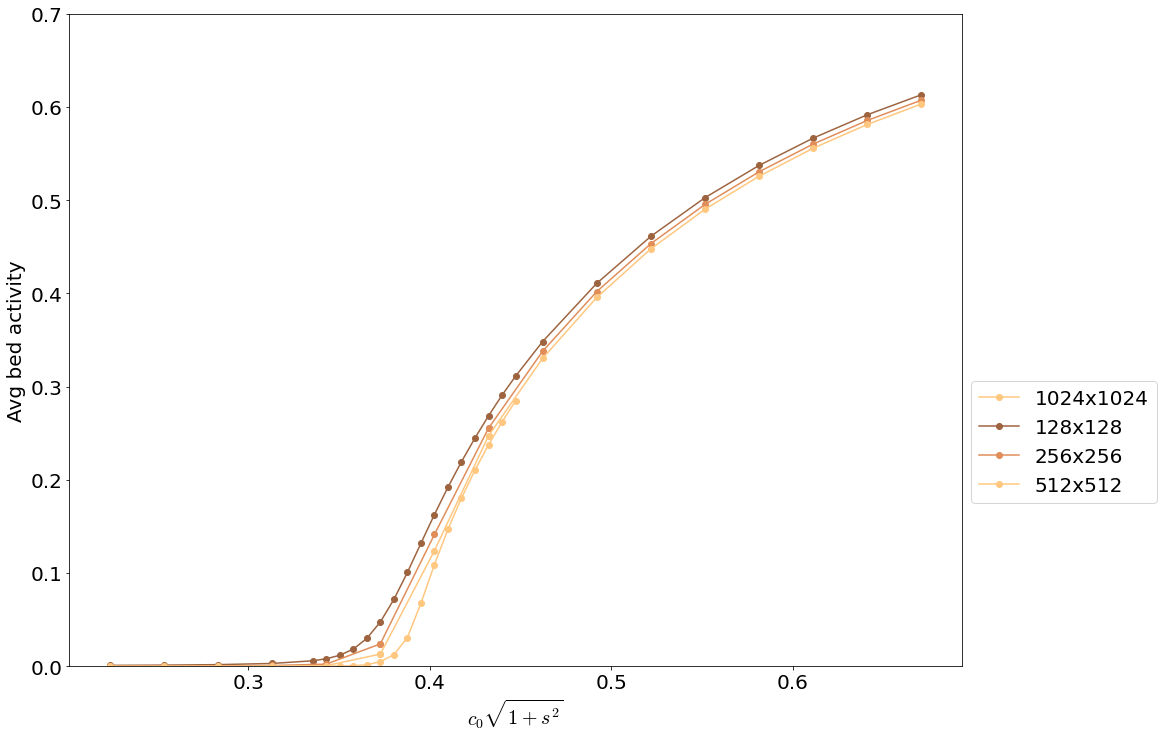

In [17]:
plt.figure(figsize=(16,12))
for dirr in ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.axhline(y=1,c='r',ls='--')
    plt.plot(c0s_d[dirr]*np.sqrt(5),ba[dirr],marker = 'o',c=cm.copper(np.sqrt(Ny/512)),ls='-',label = dirr)#,ms=20*(Nx/512)**0.7)
# xplt = np.linspace(0,np.max(q_ins_Ny),1000)
# plt.plot(xplt,xplt,'-r',label='1:1')
plt.legend(loc=(1.01,0.25))
plt.xlabel("$c_0 \sqrt{1+s^2}$")
# plt.xlabel("$q_{in}/N_y$")
plt.ylim(0,0.7)
# plt.ylabel(r"Max$(q_{out}/N_y)$")
plt.ylabel(r"Avg bed activity")
# plt.title("Measuring Bed Activity")
plt.show()

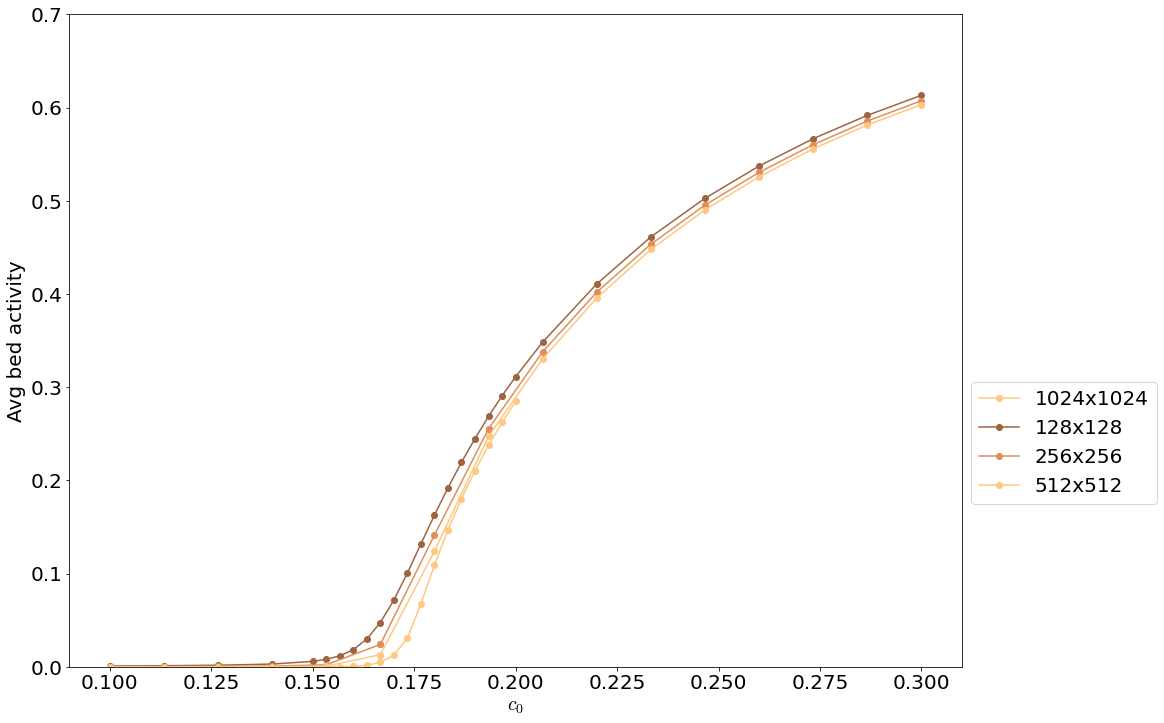

In [19]:
plt.figure(figsize=(16,12))
for dirr in ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.axhline(y=1,c='r',ls='--')
    plt.plot(c0s_d[dirr],ba[dirr],marker = 'o',c=cm.copper(np.sqrt(Ny/512)),ls='-',label = dirr)#,ms=20*(Nx/512)**0.7)
# xplt = np.linspace(0,np.max(q_ins_Ny),1000)
# plt.plot(xplt,xplt,'-r',label='1:1')
plt.legend(loc=(1.01,0.25))
plt.xlabel("$c_0$")
# plt.xlabel("$q_{in}/N_y$")
plt.ylim(0,0.7)
# plt.ylabel(r"Max$(q_{out}/N_y)$")
plt.ylabel(r"Avg bed activity")
# plt.title("Measuring Bed Activity")
plt.show()

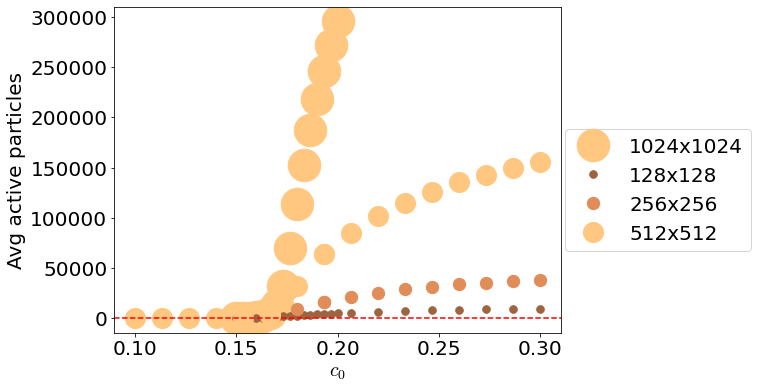

In [20]:
plt.figure(figsize=(8,6))
for dirr in ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.axhline(y=1,c='r',ls='--')
    plt.plot(c0s_d[dirr],ba[dirr]*(Nx-10)*Ny,marker = 'o',c=cm.copper(np.sqrt(Ny/512)),ms=20*(Nx/512)**0.7,ls='',label = dirr)
# xplt = np.linspace(0,np.max(q_ins_Ny),1000)
# plt.plot(xplt,xplt,'-r',label='1:1')
plt.legend(loc=(1.01,0.25))
plt.xlabel("$c_0$")
# plt.xlabel("$q_{in}/N_y$")
# plt.ylabel(r"Max$(q_{out}/N_y)$")
plt.ylabel(r"Avg active particles")
plt.axhline(y=1,color='r',ls='--')
# plt.title("Measuring Bed Activity")
plt.show()

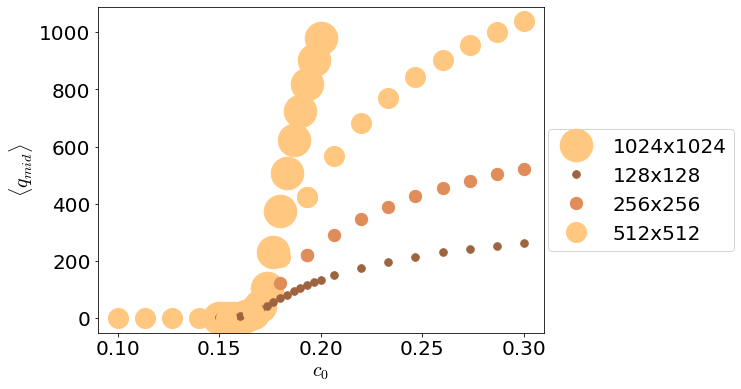

In [21]:
plt.figure(figsize=(8,6))
for dirr in ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.axhline(y=1,c='r',ls='--')
    plt.plot(c0s_d[dirr],qs[dirr],marker = 'o',c=cm.copper(np.sqrt(Ny/512)),ms=20*(Nx/512)**0.7,ls='',label = dirr)
# xplt = np.linspace(0,np.max(q_ins_Ny),1000)
# plt.plot(xplt,xplt,'-r',label='1:1')
plt.legend(loc=(1.01,0.25))
plt.xlabel("$c_0$")
# plt.xlabel("$q_{in}/N_y$")
# plt.ylabel(r"Max$(q_{out}/N_y)$")
plt.ylabel(r"$\langle q_{mid} \rangle $")
# plt.title("Measuring Bed Activity")
plt.show()

# Time series

## Bed activity

In [22]:
# # idir = '../1024x1024_f'
# # idir = '../512x512_f'
# idir = '../256x256_f'

# dirs = glob.glob(idir+'/*/*_scalars.h5')

# runs = []
# for file in dirs:
#     run = file.split('/')[2]
#     runs.append(run)

# # Sort run-names based on value of c_0
# runs = sorted(runs, key=lambda x: float(x.split('_')[2].replace('d','.')), reverse=False)

# print(runs)

# for ii,run in enumerate(runs):
#     # Open 
#     fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
# #     file = h5py.File(fname,'r')
#     with h5py.File(fname,'r') as file:
#         Nx = file['parameters']['Nx'][()]
#         Ny = file['parameters']['Ny'][()]
#         c_0 = file['parameters']['c_0'][()]
#         f = file['parameters']['f'][()]
#         u_p = file['parameters']['u_p'][()]
#         skipmax = file['parameters']['skipmax'][()]    

#         # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last']
#         time = file['scalars']['time'][()]
#         #     tstep = file['scalars']['tstep'][()]
#         bed_activity = file['scalars']['bed_activity'][()]
# #         q = file['scalars']['q_mid'][()]

#     # Close file:
# #     file.close()

#     plt.figure(figsize=(8,6))
# #     plt.plot(time[-5000:],bed_activity[-5000:])
# #     plt.axhline(y=f,c='r',ls='--')
# #     plt.ylabel(r"Bed Activity")
#     plt.plot(time[time>10],bed_activity[time>10])
#     plt.ylabel(r"$q_{mid}$")
#     plt.xlabel("Time")
#     plt.title(r'$(Nx,Ny) =$ (%s,%s), $c_0 = $ %.3e' % (Nx,Ny,c_0))
#     plt.show()

## Time series PDFs

In [26]:
slopes_ba = dict([])
qin_reals_ba = dict([])
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(runs):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['q_mid'][()]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid

        pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 3/norm,xmax = max(q), output='pdf')

        # Finite size effect cutoff
        nbeads = 3 # Number of grains considered 'too small' x avg skipmax
        xcutoff = nbeads/norm # Five grains active total

        xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

#         if idir=='../256x256/':
        plt.figure(figsize=(8,6))
        plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
        plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        
#         # Fit
#         if ((idir=='../400x80/') or (idir=='../128x128/')):
#             fitmax = 1e-2  # For 200x40
#         elif (idir=='../256x256/'):
#             fitmax = 5e-3
#         else:
#             fitmax = 2e-3  # For 400x80
        fitmin = xcutoff 
        fitmax = 15/norm
        xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
        pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# #         print(idir, run)
        m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
#         if idir=='../256x256/':
        xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
        plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
        plt.legend()#loc=(1.01,0.0))
#         plt.xlabel(r"Bed Activity")
        plt.xlabel(r"$q^*_{mid}$")
        slopes_l.append(m)
        q8s_l.append(q8_in)
#         else:
#             plt.figure(figsize=(8,6))
#             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
#             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
#             slopes_ba_400.append(m)
#             q8_ins_ba_400.append(q8_in)
        plt.show()
        plt.close()


    slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
    qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

        

Working on ../1024x1024_f
Working on ../128x128_f
Working on ../256x256_f
Working on ../512x512_f


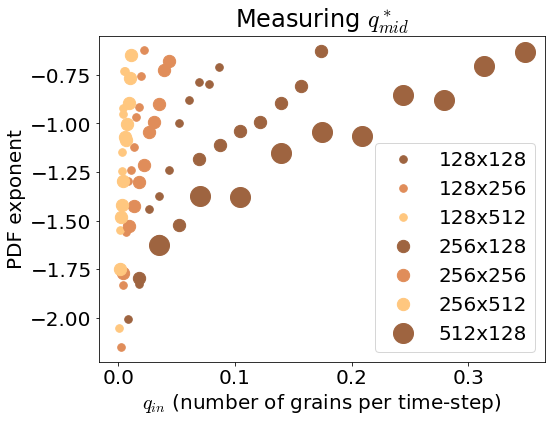

In [34]:
plt.figure(figsize=(8,6))
# plt.semilogx(q8_ins_ba,slopes_ba,'ok')
for dirr in slopes_ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
    plt.plot(qin_reals_ba[dirr],slopes_ba[dirr],marker = 'o',c=cm.copper(np.sqrt(Ny/512)),ms=20*(Nx/512)**0.7,ls='',label = dirr)
plt.legend()
# plt.xlabel("$q^*_{in}$")
plt.xlabel("$q_{in}$ (number of grains per time-step)")
plt.ylabel("PDF exponent")
plt.title(r"Measuring $q^*_{mid}$")
plt.show()

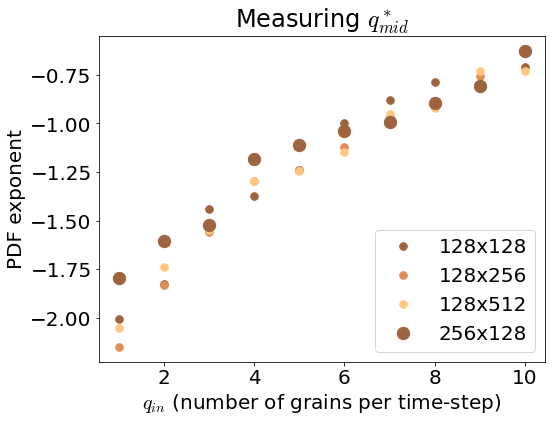

In [81]:
plt.figure(figsize=(8,6))
# plt.semilogx(q8_ins_ba,slopes_ba,'ok')
for dirr in slopes_ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
    plt.plot(qin_reals_ba[dirr],slopes_ba[dirr],marker = 'o',c=cm.copper(np.sqrt(Ny/512)),ms=20*(Nx/512)**0.7,ls='',label = dirr)
plt.legend()
# plt.xlabel("$q^*_{in}$")
plt.xlabel("$q_{in}$ (number of grains per time-step)")
plt.ylabel("PDF exponent")
plt.title(r"Measuring $q^*_{mid}$")
plt.show()

## Bed activity PDF

In [27]:
# slopes_ba = dict([])
# qin_reals_ba = dict([])
# for idir in idirs:
#     print("Working on %s" % idir)
#     ba_l = []
#     qs_l = []
#     c0s_l = []
    
# #     dirs = sorted(glob.glob(idir+'/c_0*'))
#     dirs = glob.glob(idir+'/*/*_scalars.h5')
    
#     runs = []
#     for file in dirs:
#         run = file.split('/')[2]
#         runs.append(run)

#     # Sort run-names based on value of c_0
#     runs = sorted(runs, key=lambda x: float(x.split('_')[2].replace('d','.')), reverse=False)

#     for ii,run in enumerate(runs):
#         # Open 
#         fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
#         with h5py.File(fname,'r') as file:
#             Nx = file['parameters']['Nx'][()]
#             Ny = file['parameters']['Ny'][()]
#             c_0 = file['parameters']['c_0'][()]
#             f = file['parameters']['f'][()]
#             u_p = file['parameters']['u_p'][()]
#             skipmax = file['parameters']['skipmax'][()]    

#             # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last']
#             time = file['scalars']['time'][()]
#     #         tstep = file['scalars']['tstep'][()]
#             bed_activity = file['scalars']['bed_activity'][()]
#             q = file['scalars']['q_mid'][()]

#     #     if (q_in_real<3):
#         nbin = 20

#         # Choose data to plot:
#         q = bed_activity        
        
#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/Nx/Ny # Five grains active total

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = xcutoff,xmax = max(q), output='pdf')

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

# #         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c=cm.copper(np.sqrt(Ny/512)),label = r"$c_0 =$ %.3e, %sx%s" % (c_0,Nx,Ny),ms=10)
# #         plt.axvline(x=30*q_in_real/Ny/Nx,c='r',ls='--')
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
# #         fitmin = xcutoff 
# #         fitmax = 30*q_in_real/Ny/Nx
# #         xfit = x[(x<fitmax)&(pdf>3e-2)&(pdf>0)]
# #         pdffit = pdf[(x<fitmax)&(pdf>3e-2)&(pdf>0)]
# # # #         print(idir, run)
# #         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# # #         if idir=='../256x256/':
# #         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
# #         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
#         plt.xlabel(r"Bed Activity")
# #         plt.xlabel(r"$q^*_{mid}$")
# #         slopes_l.append(m)
# #         q8s_l.append(q_in_real)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)
#         plt.show()
#         plt.close()


#     slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
#     qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

        

Working on ../1024x1024_f


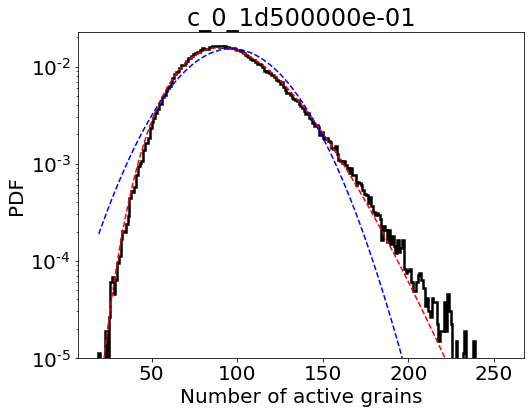

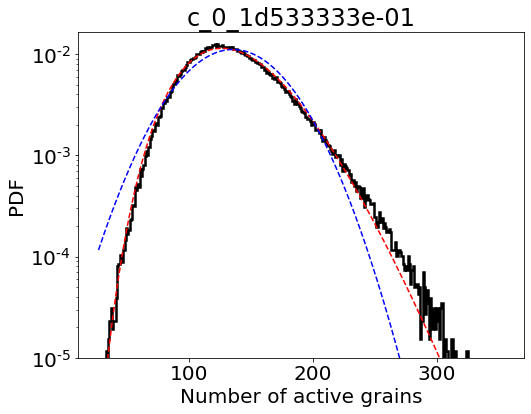

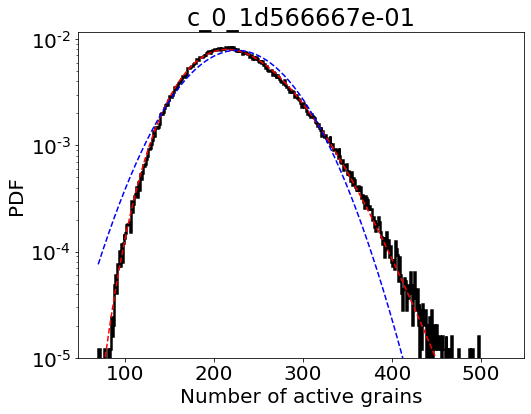

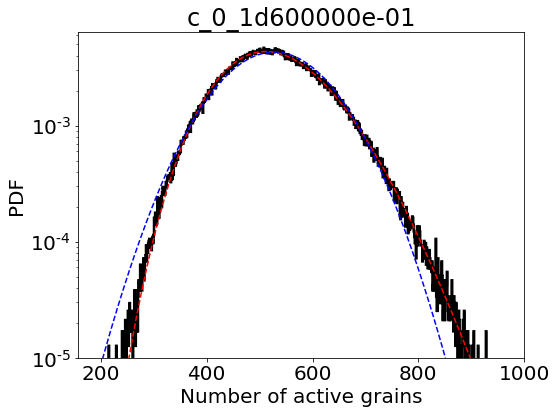

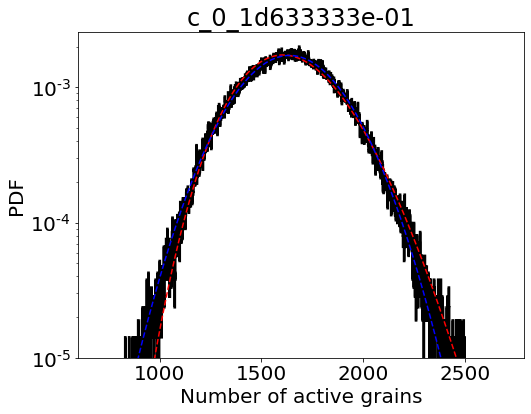

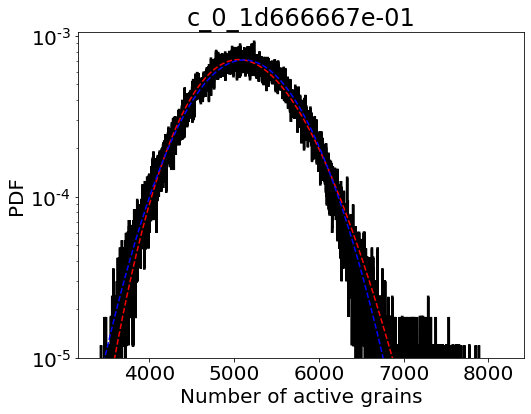

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


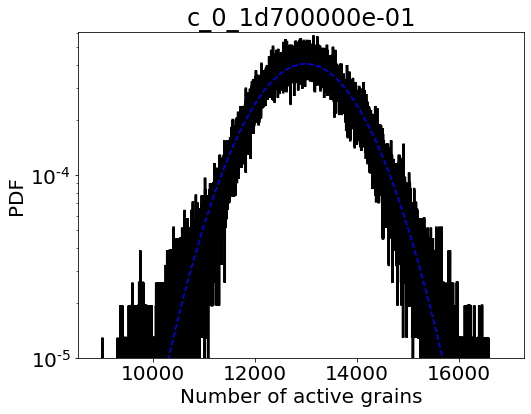

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


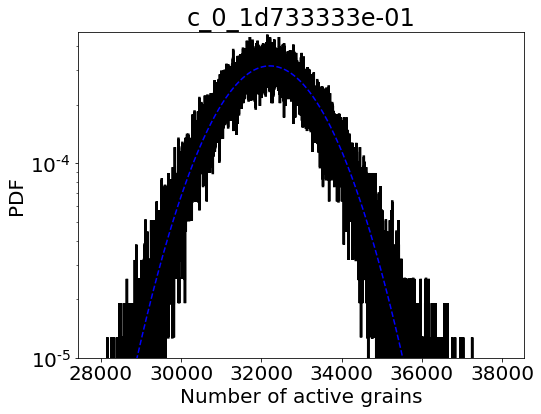

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


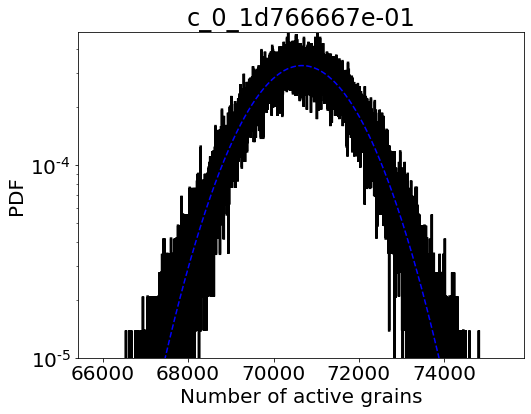

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


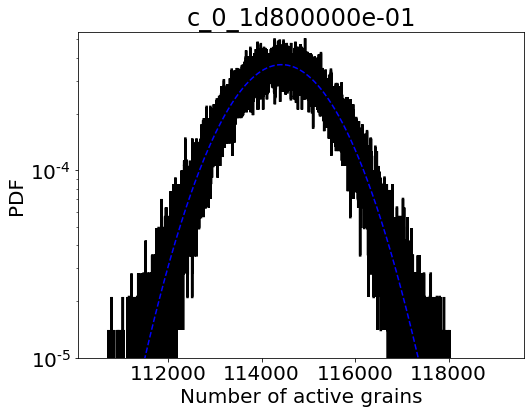

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


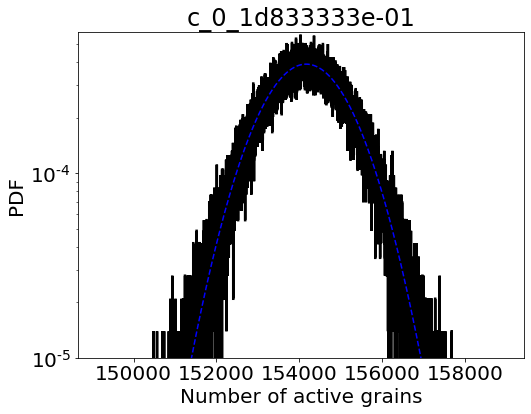

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


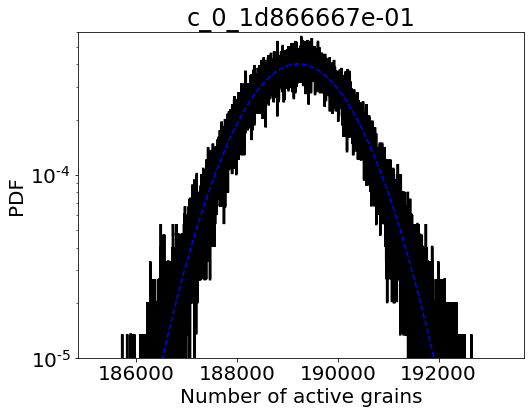

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


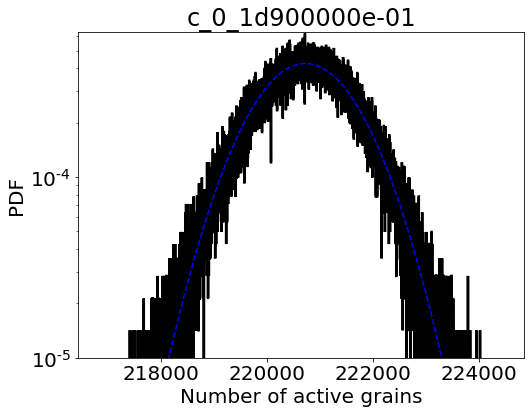

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


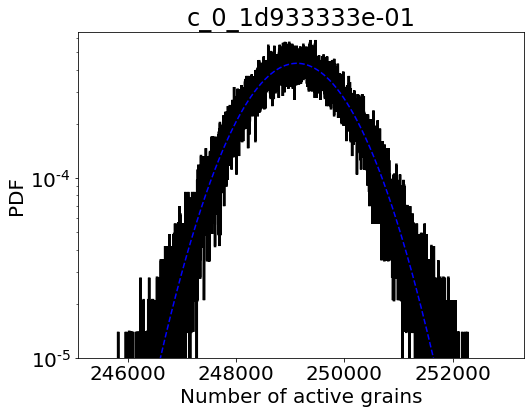

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


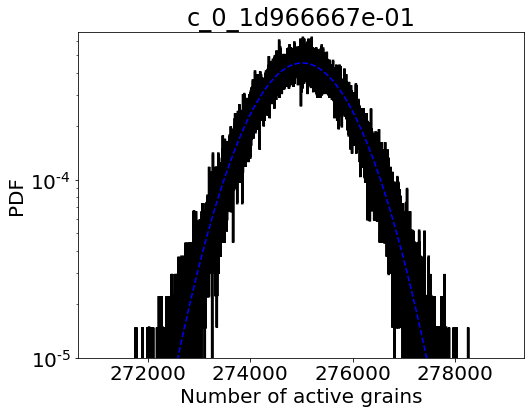

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


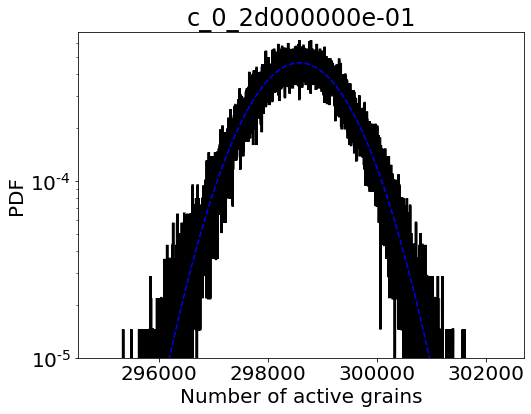

Working on ../128x128_f


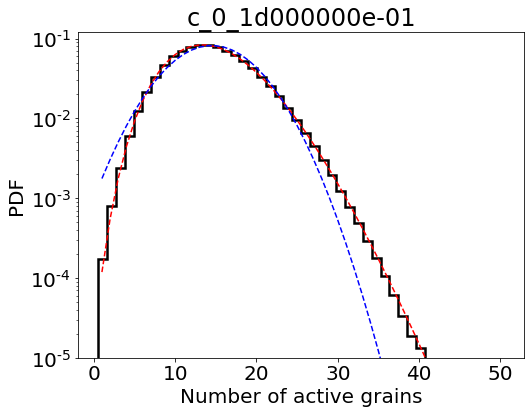

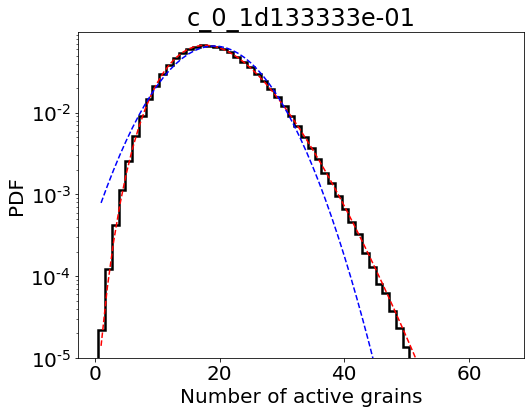

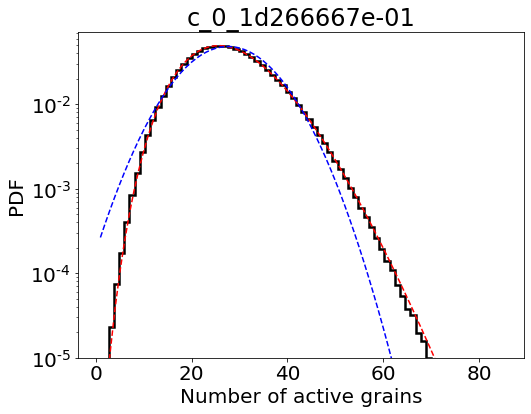

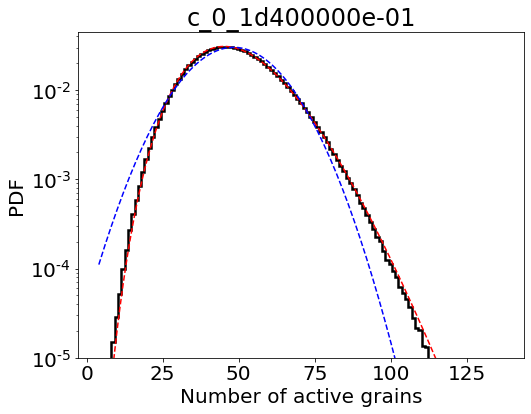

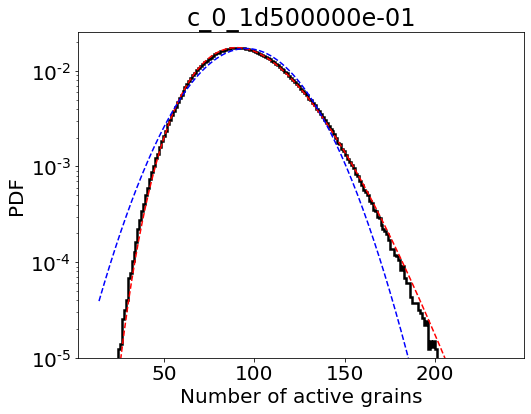

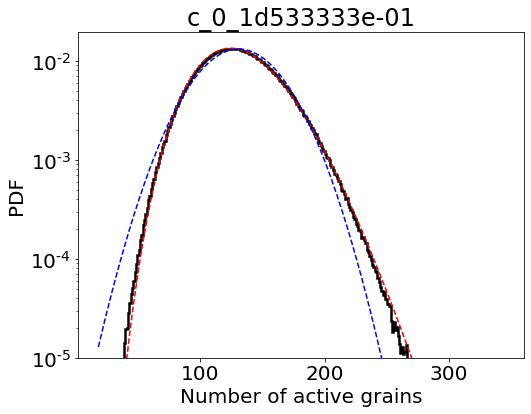

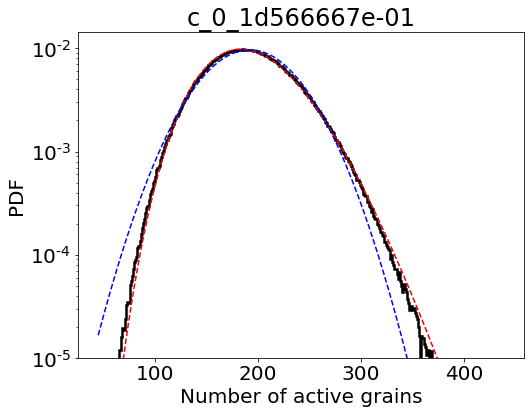

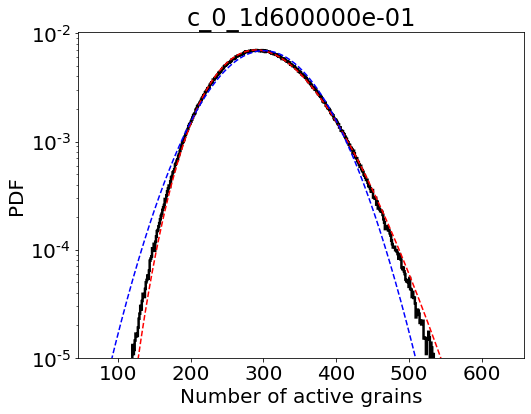

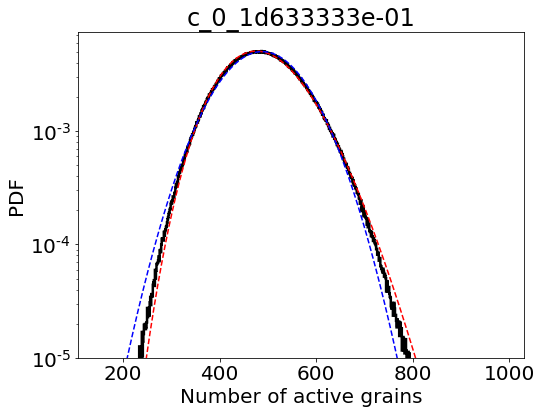

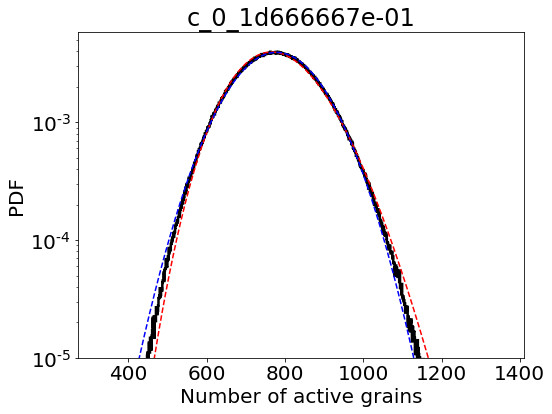

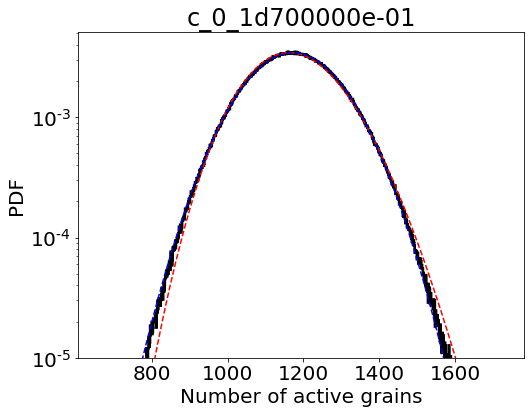

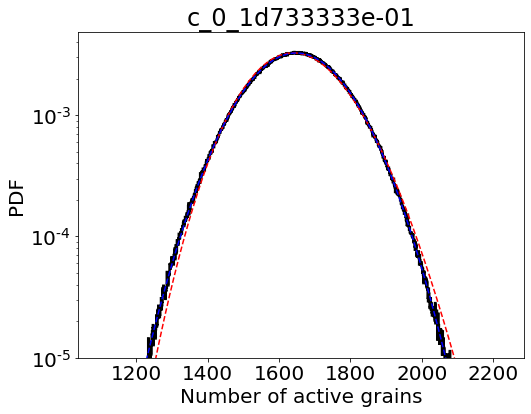

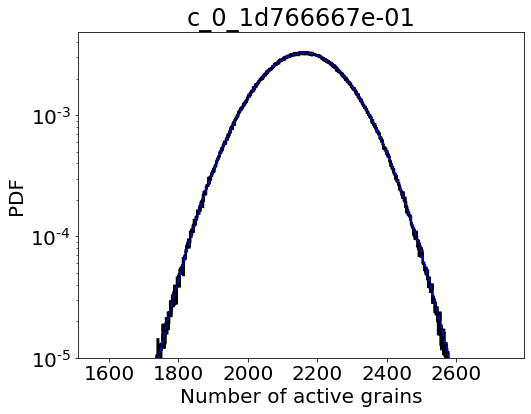

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


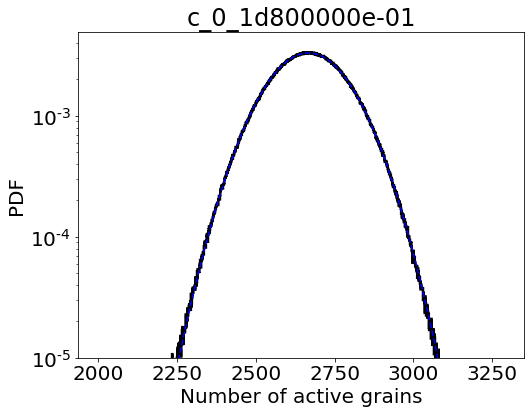

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


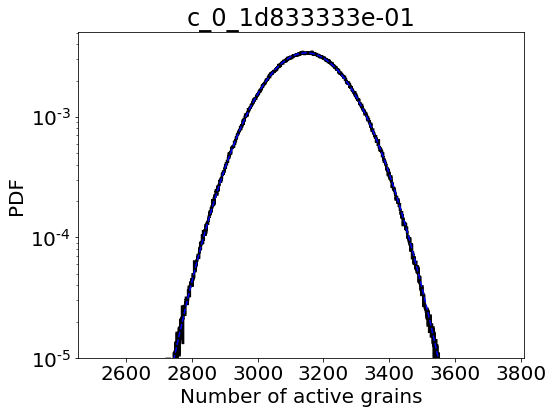

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


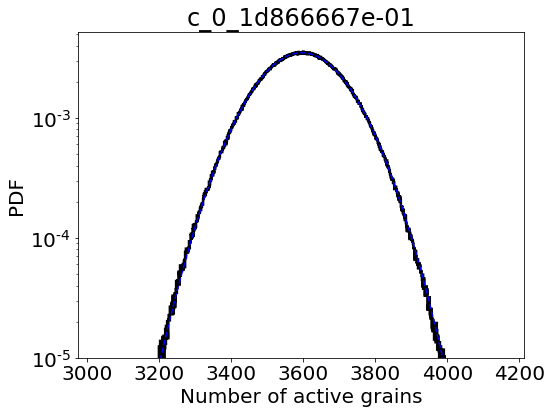

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


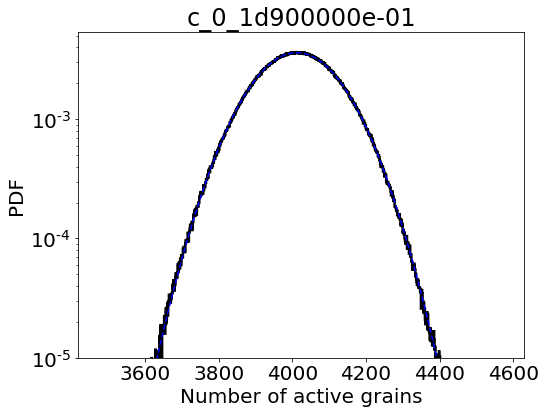

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


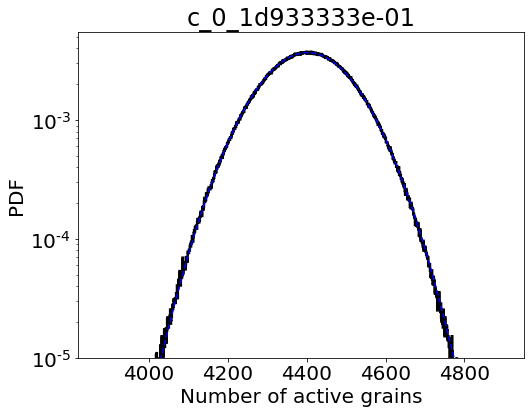

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


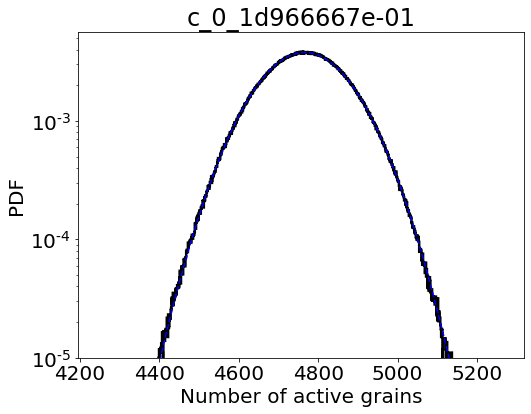

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


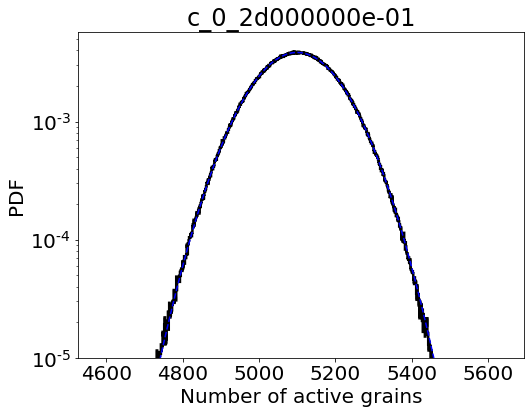

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


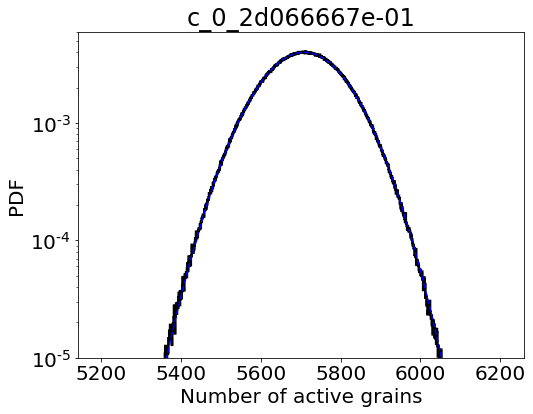

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


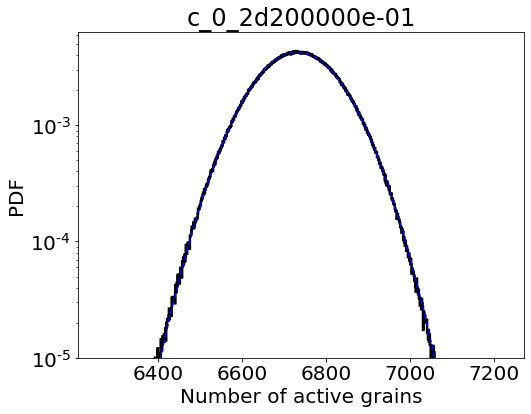

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


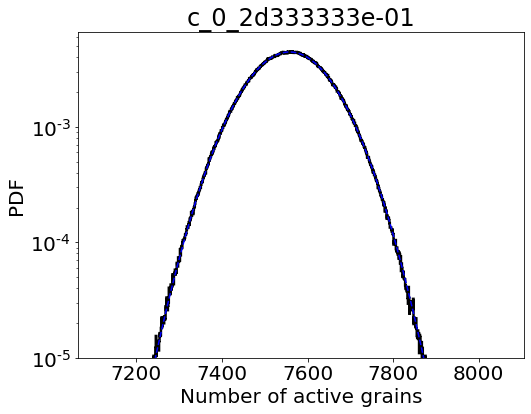

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


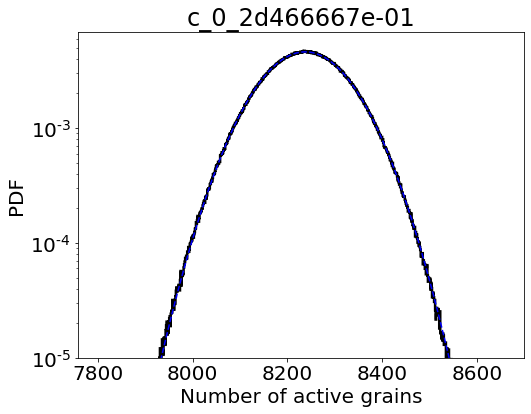

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


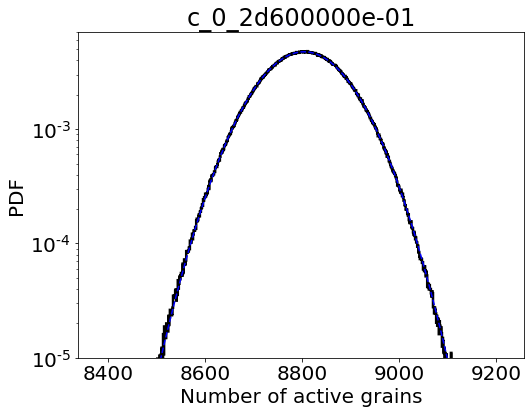

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


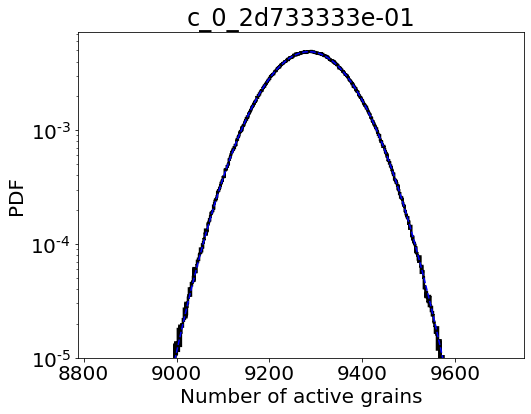

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


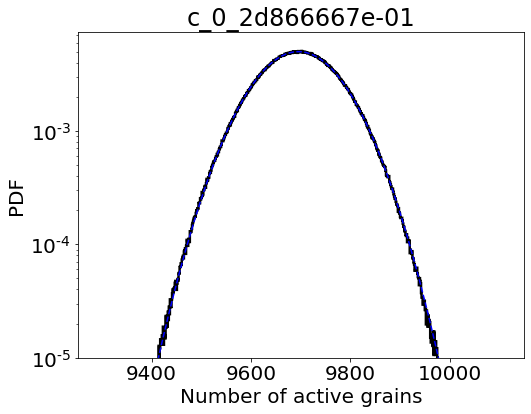

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


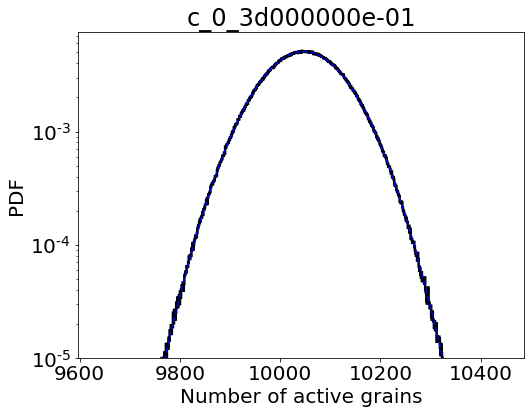

Working on ../256x256_f


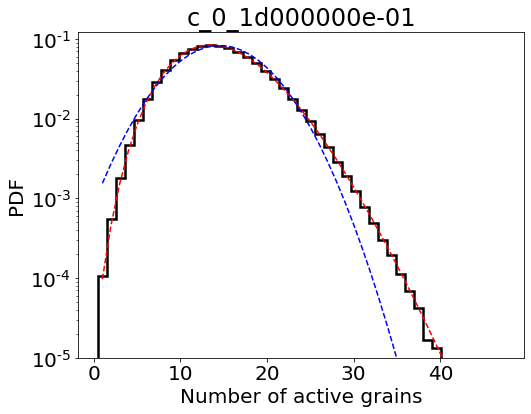

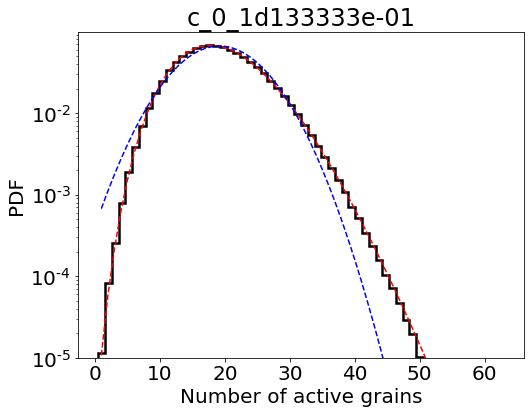

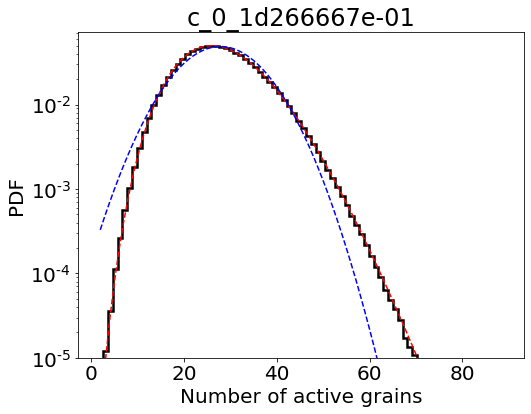

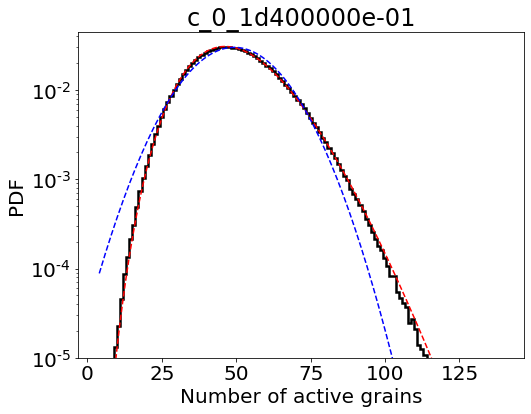

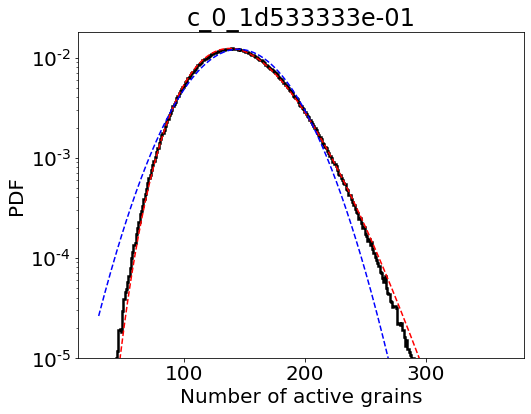

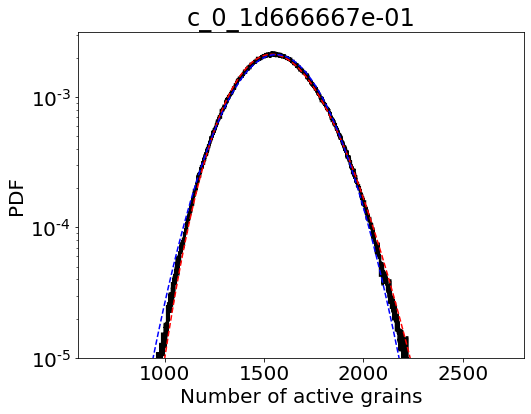

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


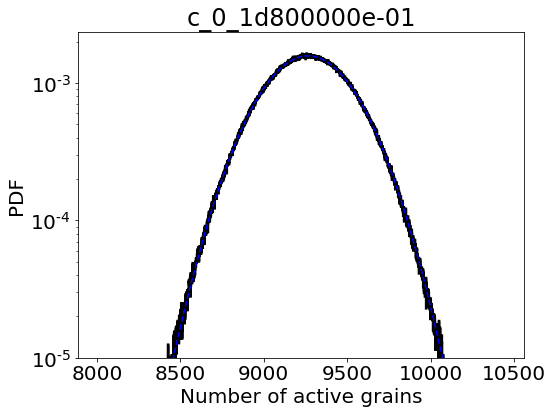

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


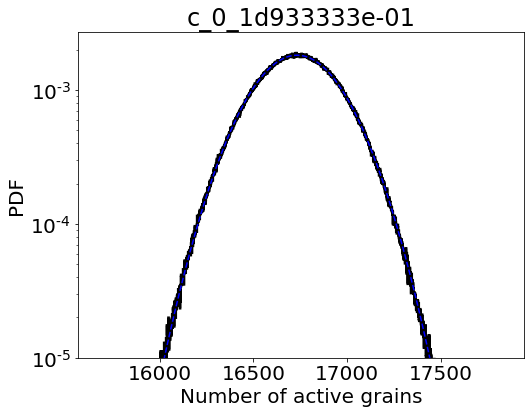

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


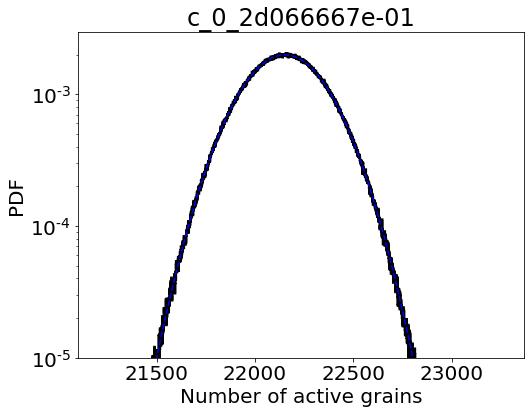

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


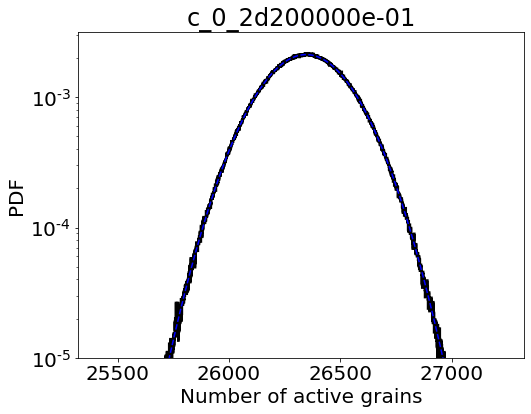

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


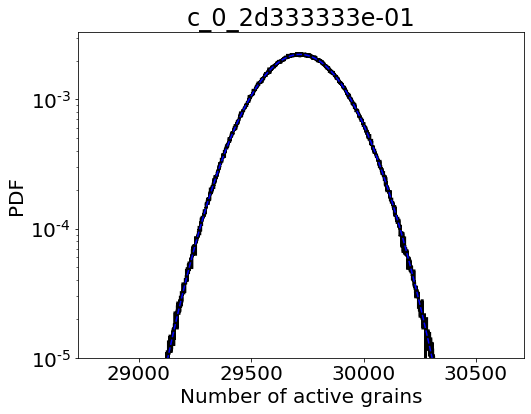

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


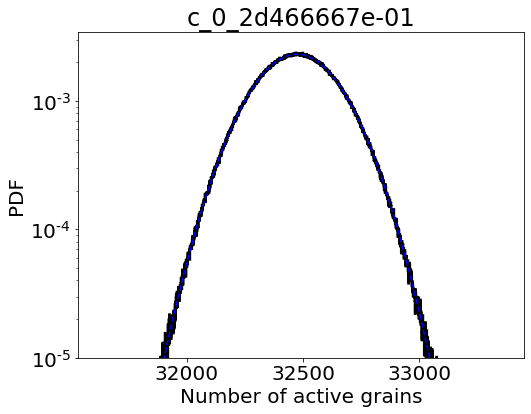

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


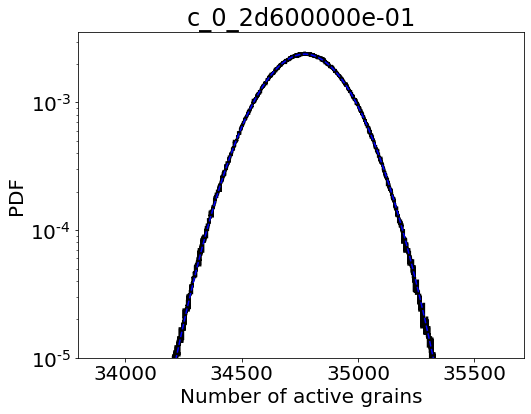

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


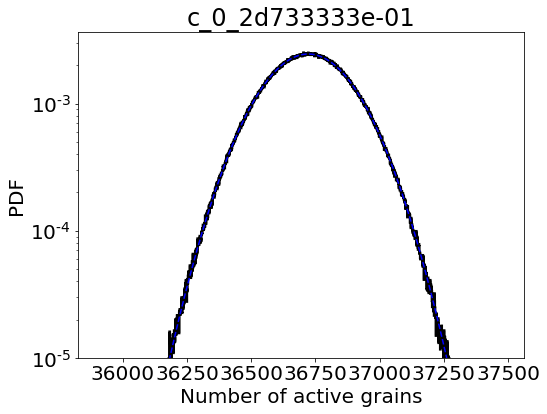

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


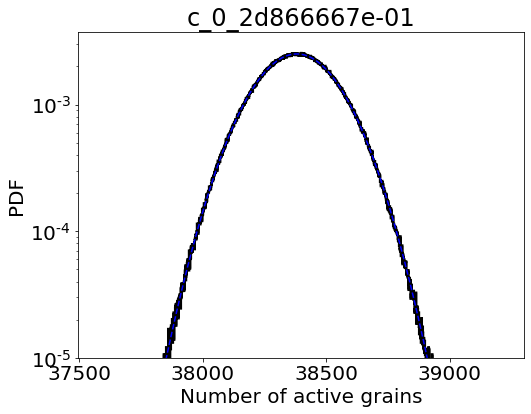

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


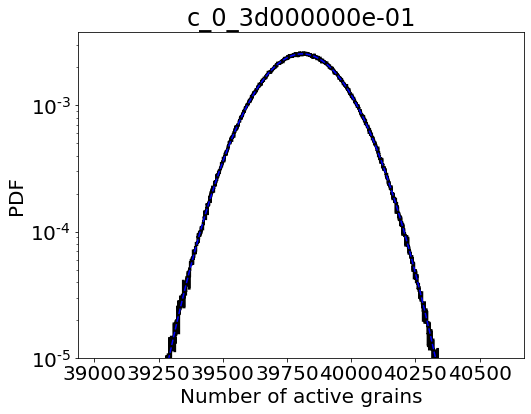

Working on ../512x512_f


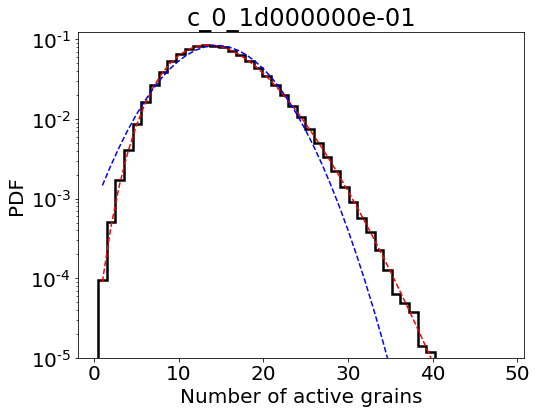

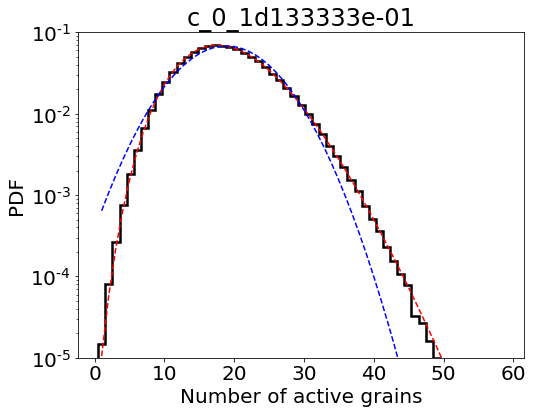

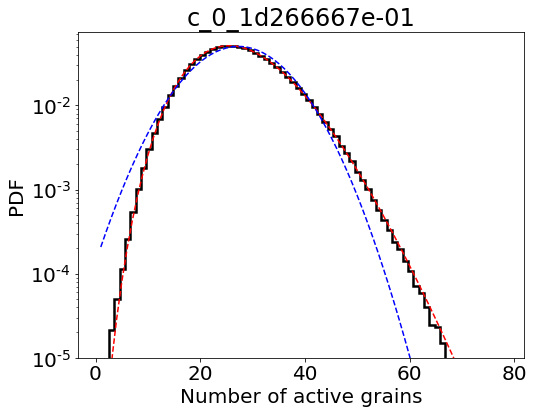

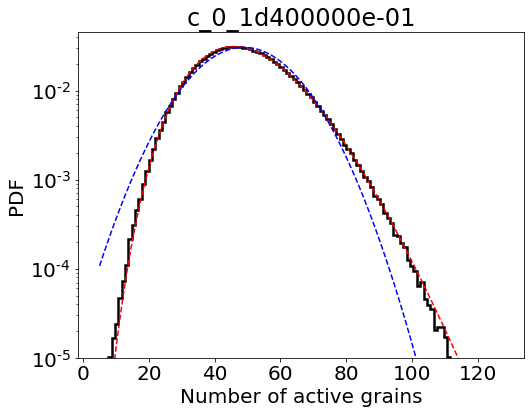

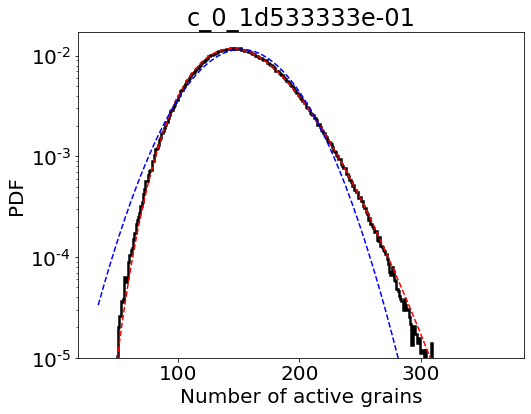

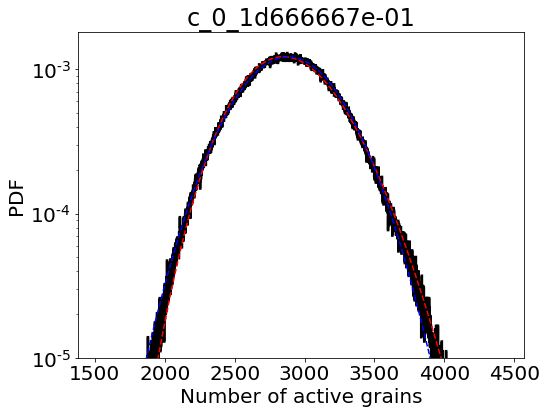

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


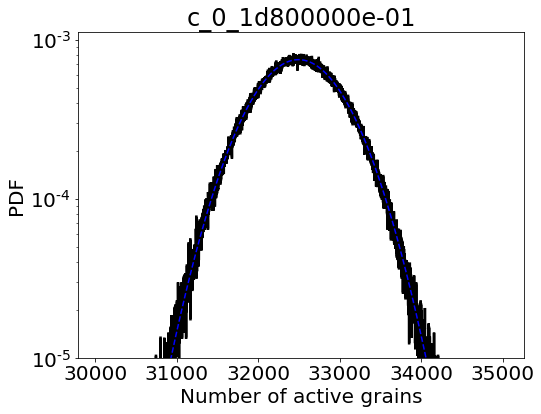

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


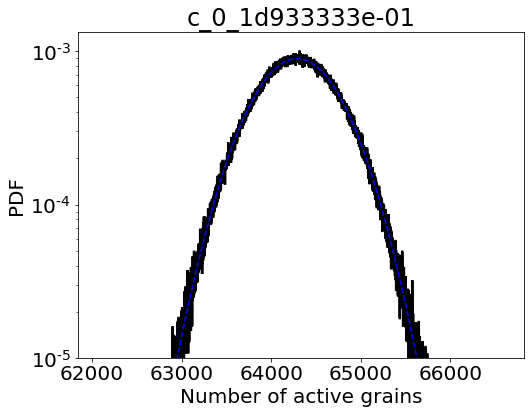

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


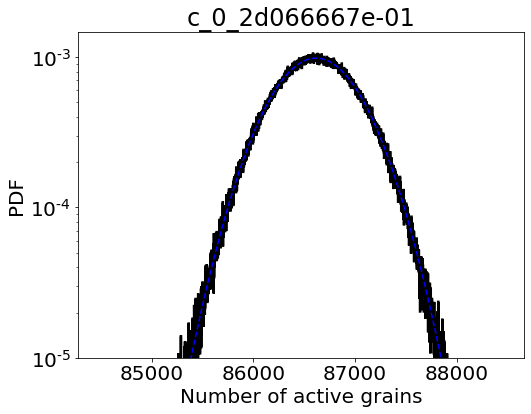

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


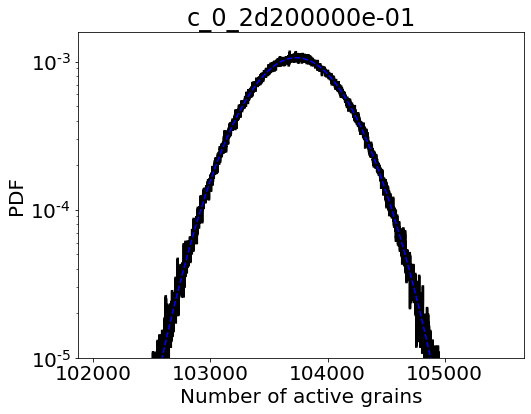

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


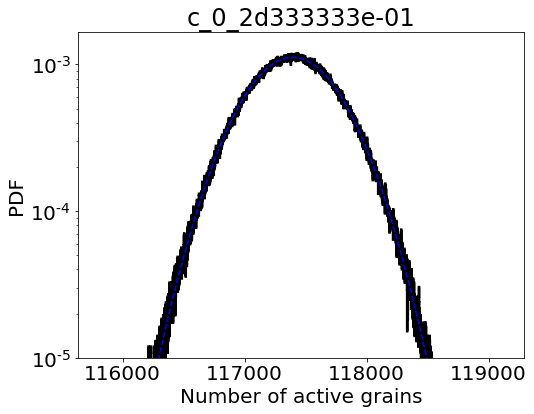

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


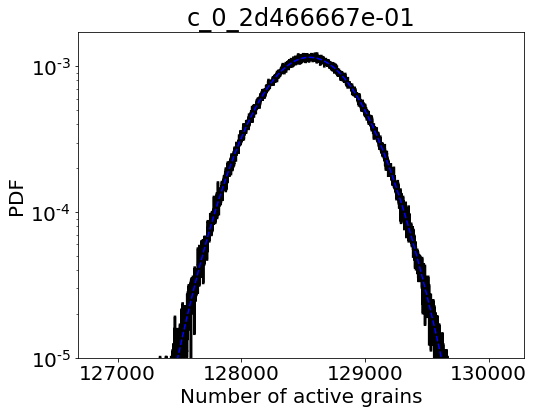

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


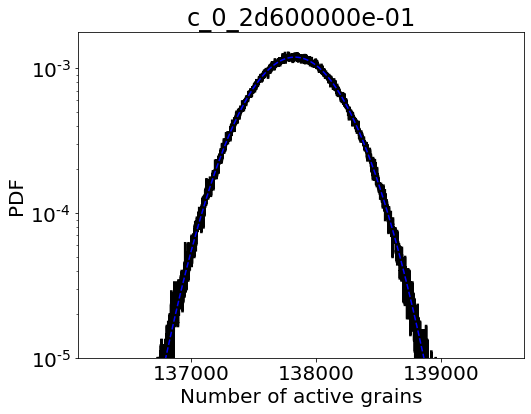

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


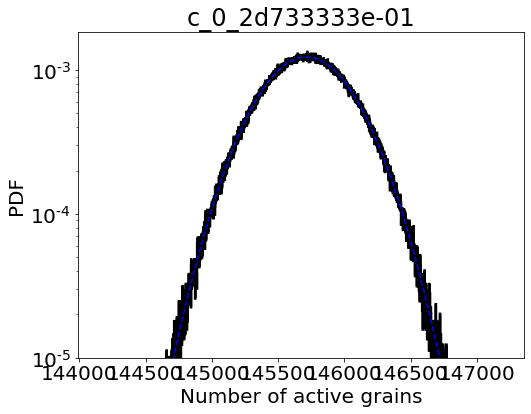

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


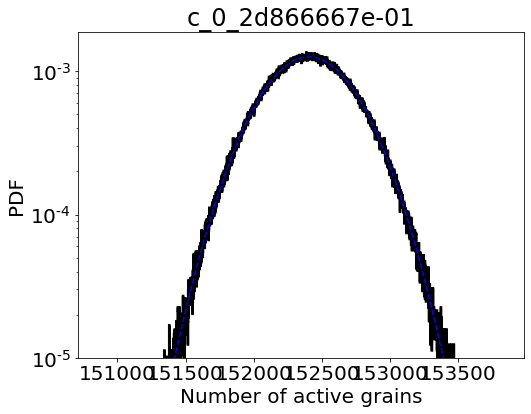

<ipython-input-5-e8af55b7ebca>:10: RuntimeWarning: invalid value encountered in multiply
  return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r


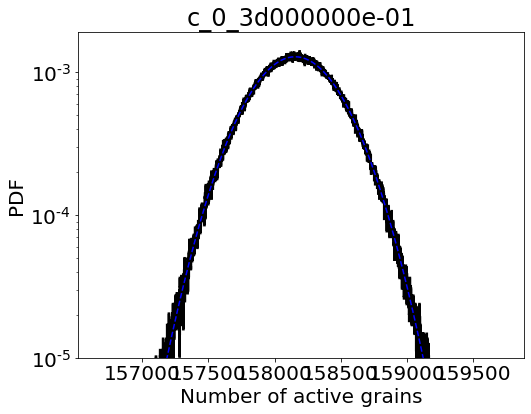

In [19]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plot_yn=False
for idir in idirs:
    print("Working on %s" % idir)
    ba_l = []
    qs_l = []
    c0s_l = []
    
#     dirs = sorted(glob.glob(idir+'/c_0*'))
    dirs = glob.glob(idir+'/*/*_scalars.h5')
    
    runs = []
    for file in dirs:
        run = file.split('/')[2]
        runs.append(run)

    # Sort run-names based on value of c_0
    runs = sorted(runs, key=lambda x: float(x.split('_')[2].replace('d','.')), reverse=False)

    for ii,run in enumerate(runs):
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        with h5py.File(fname,'r') as file:
            Nx = file['parameters']['Nx'][()]
            Ny = file['parameters']['Ny'][()]
            c_0 = file['parameters']['c_0'][()]
            f = file['parameters']['f'][()]
            u_p = file['parameters']['u_p'][()]
            skipmax = file['parameters']['skipmax'][()]    

            # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last']
            time = file['scalars']['time'][()]
    #         tstep = file['scalars']['tstep'][()]
            bed_activity = file['scalars']['bed_activity'][()]
            q = file['scalars']['q_mid'][()]

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = bed_activity[bed_activity>0]*Ny*Nx

        plt.figure(figsize=(8,6))

#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,color='k')#,
#                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)))#,label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
        
        xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
#         plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',color = 'r')#cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        plt.plot(xplt,GaussDist(xplt,np.mean(q),np.var(q)),'--',color = 'b')#cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        
        
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


#     slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
#     qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

# plt.ylim(0,0.35)
# plt.xlim(-5,5)
# plt.xlabel(r"$\left(e_{mid}-\langle e_{mid}\rangle\right) / \sqrt{\langle e_{mid} \rangle }$")

        # ax=plt.gca()
        # ax.set_yscale('log')
        # plt.xlabel(r"$q_{out}$")
        plt.ylim(1e-5,np.max(GaussDist(xplt,np.mean(q),np.var(q)))*1.5)
#         plt.xlabel(r"$N_{mid}$")
        plt.xlabel(r"Number of active grains")
        plt.ylabel("PDF")
        plt.title(run)
#         plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000"+r" $q^*_{in} =$ %.3f" % (q8_in))
#         plt.legend(loc=(1.01,0.0))
        plt.show()
        plt.close()  

Working on ../1024x1024_f


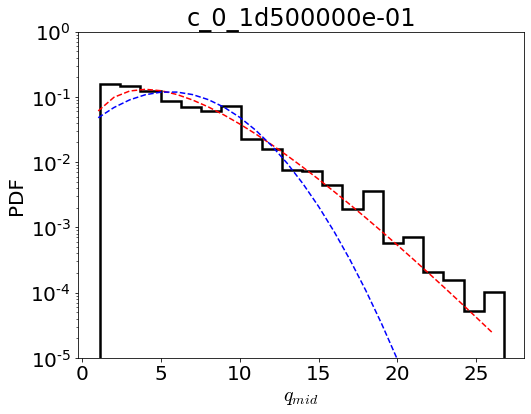

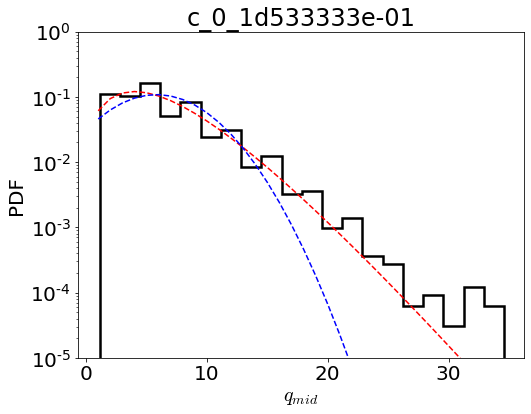

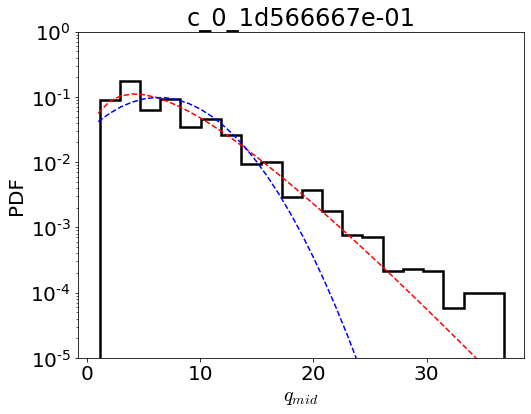

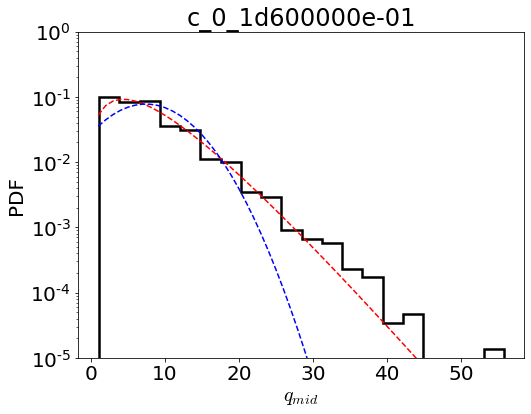

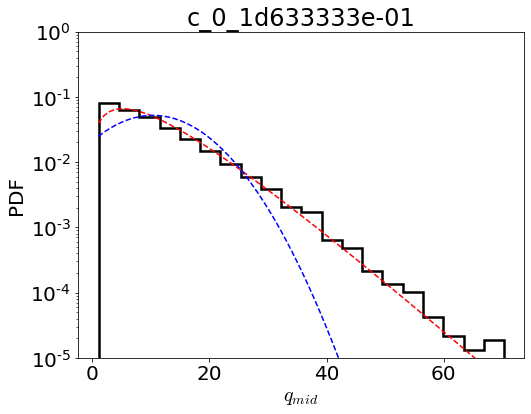

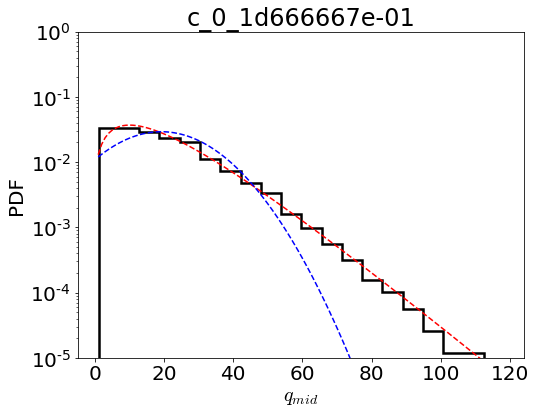

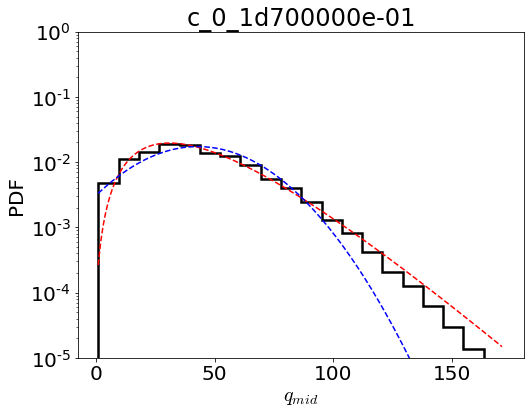

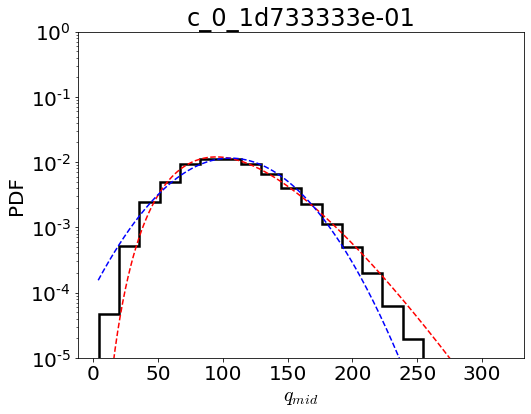

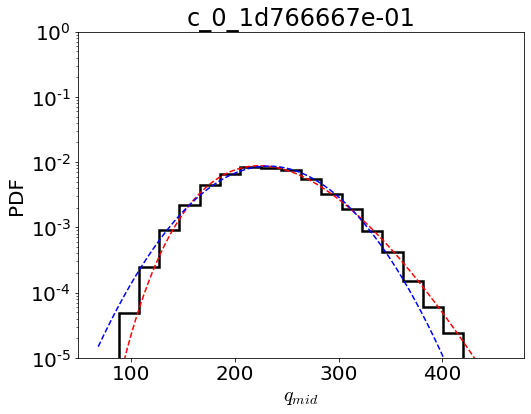

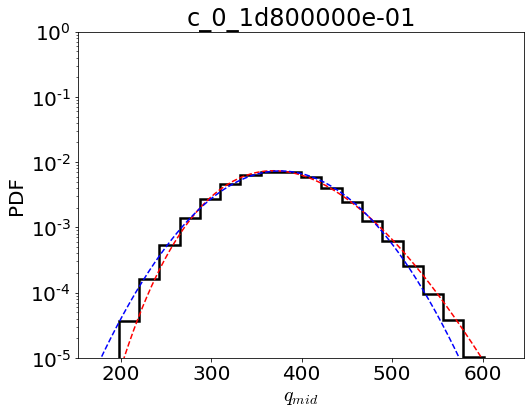

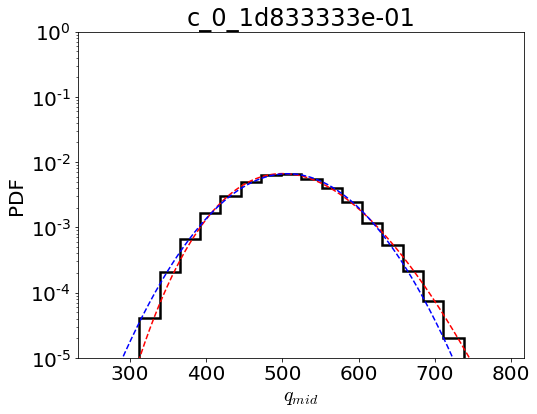

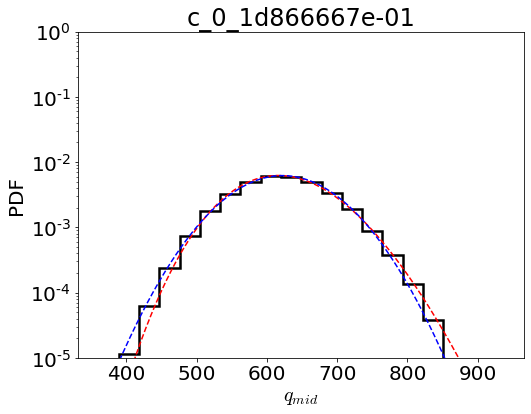

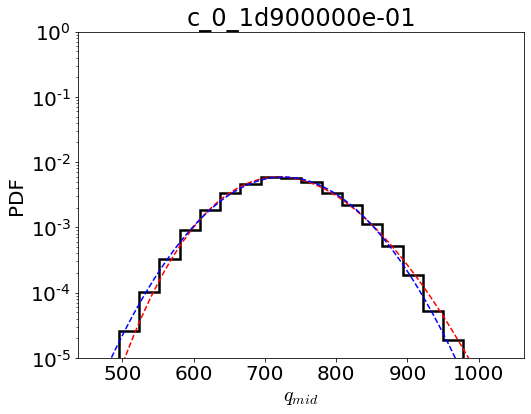

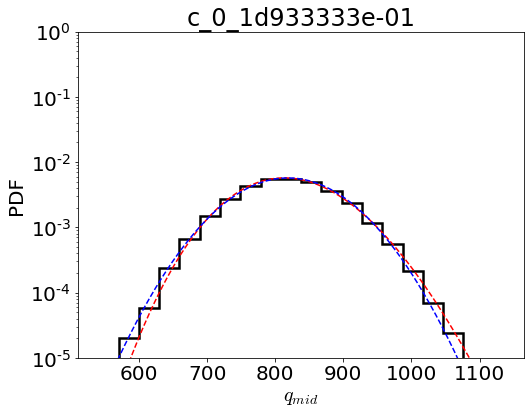

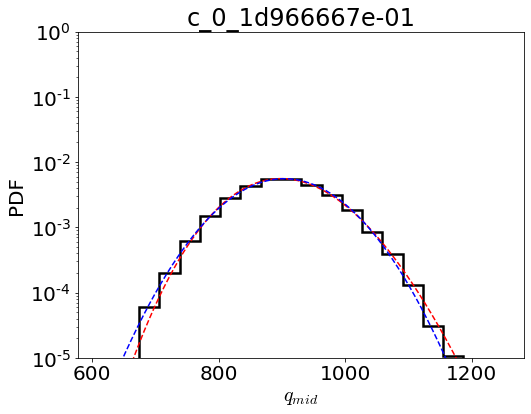

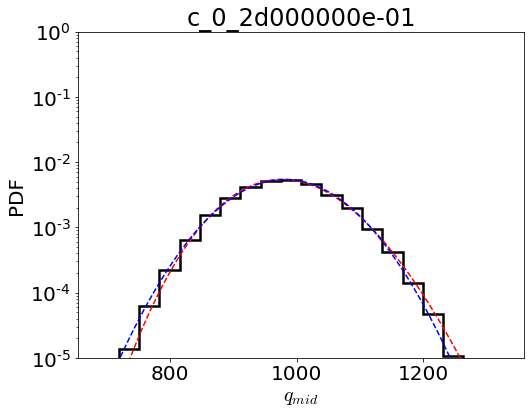

Working on ../128x128_f


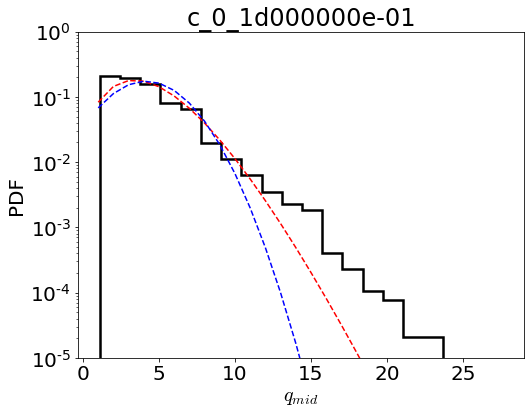

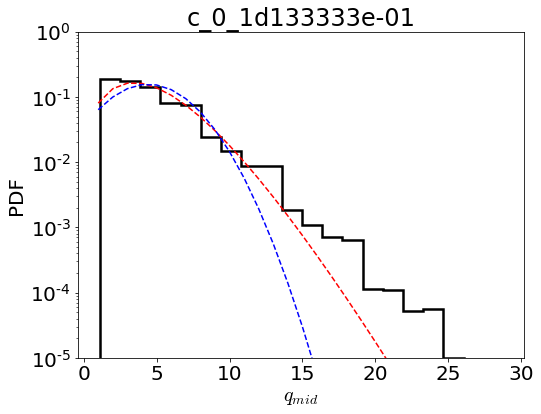

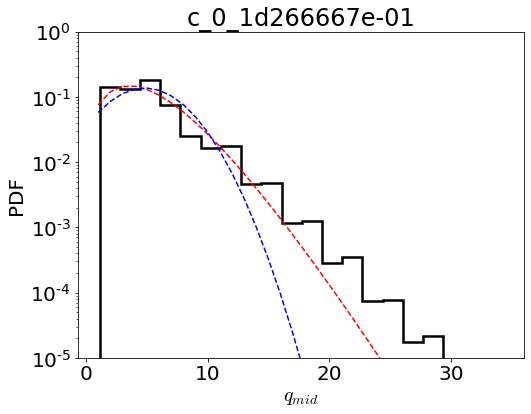

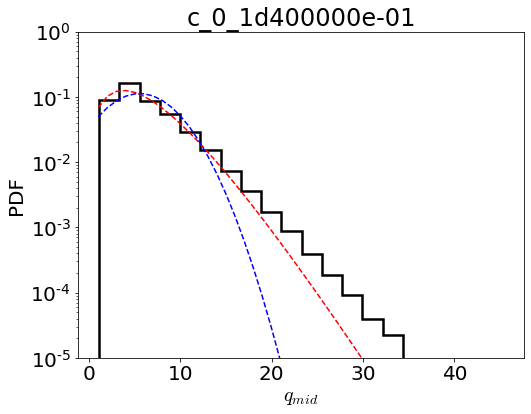

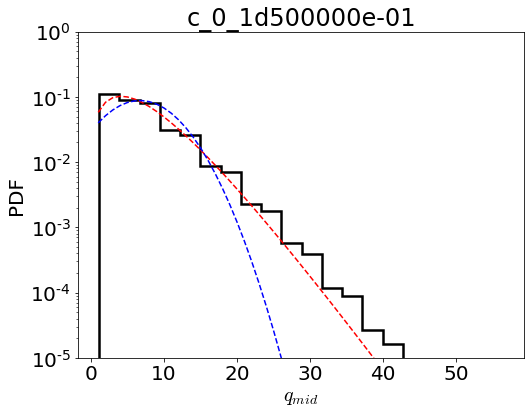

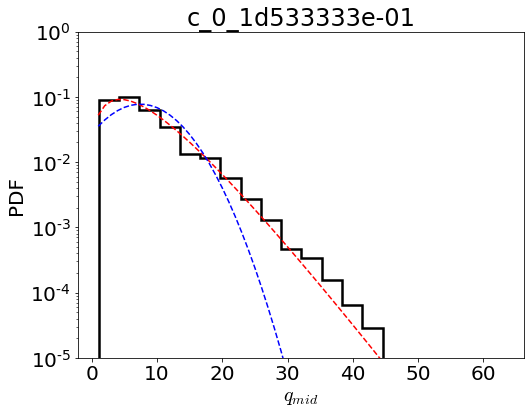

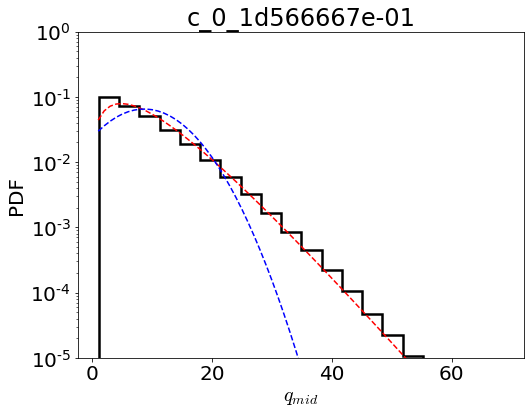

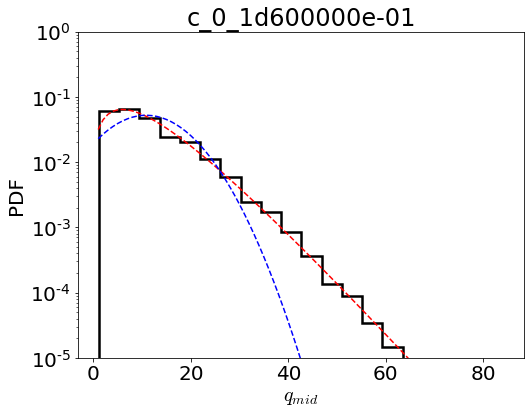

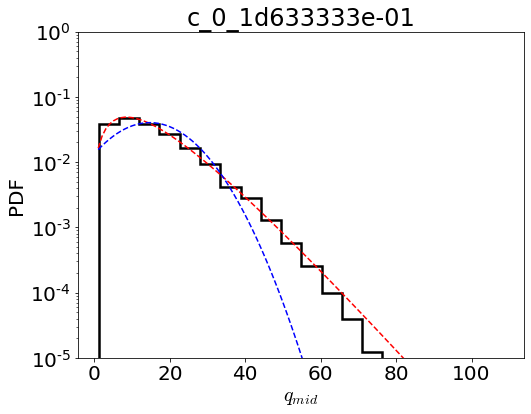

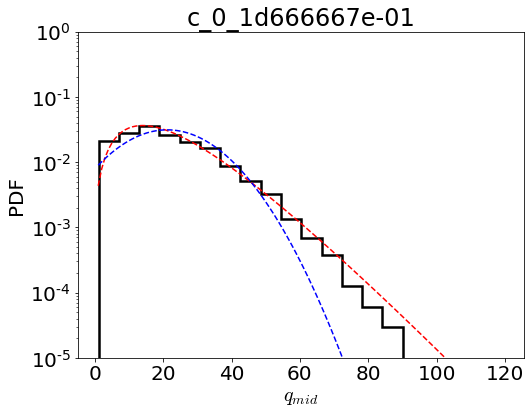

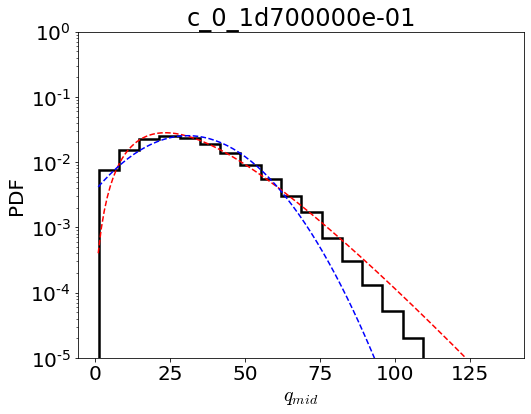

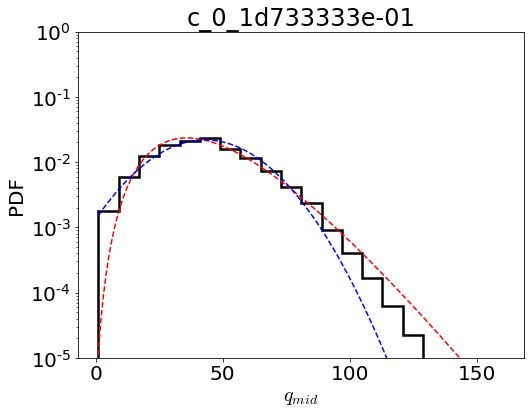

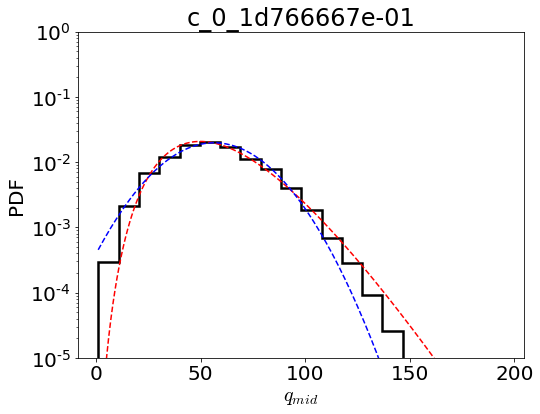

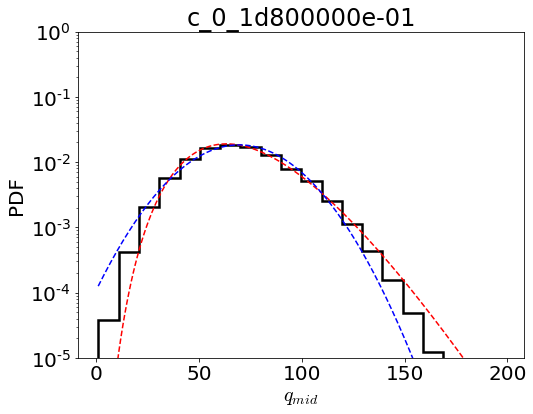

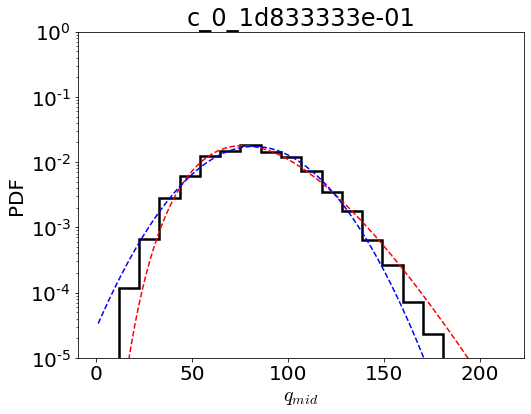

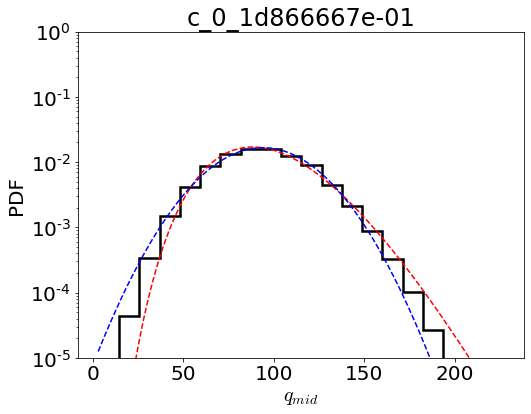

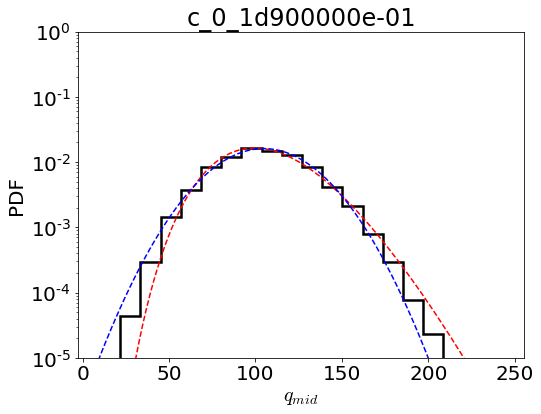

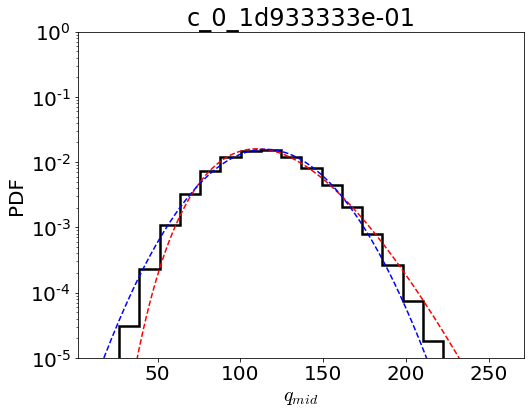

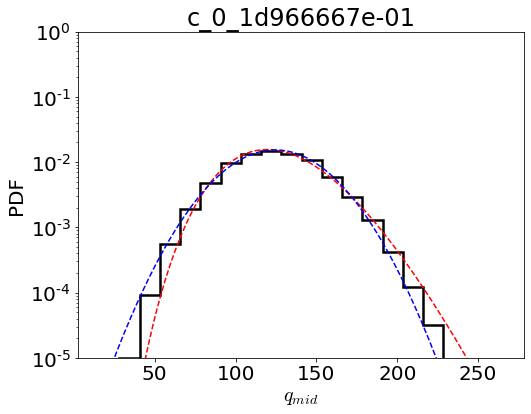

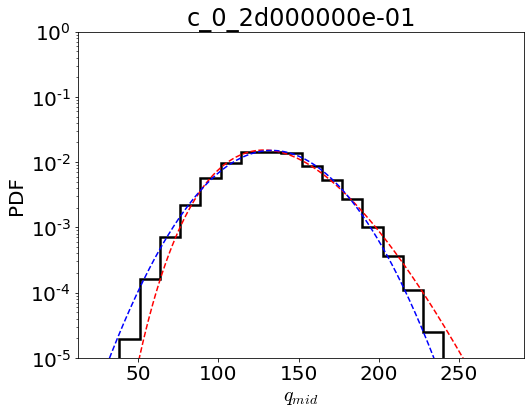

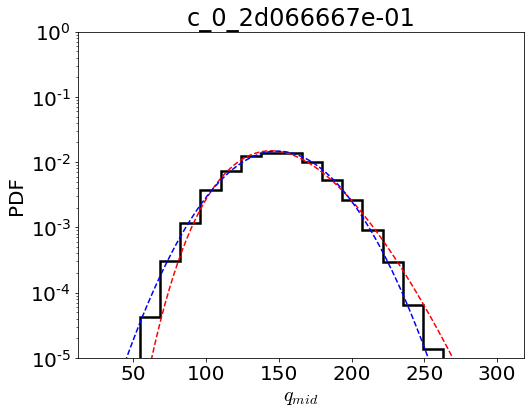

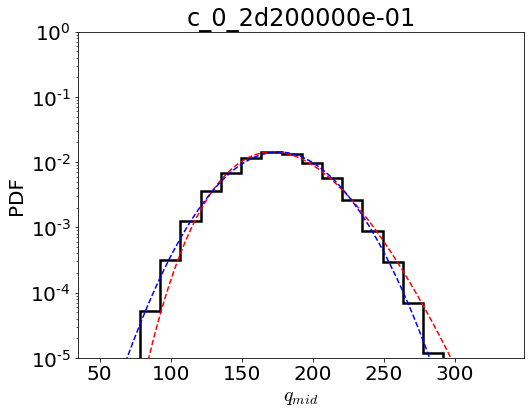

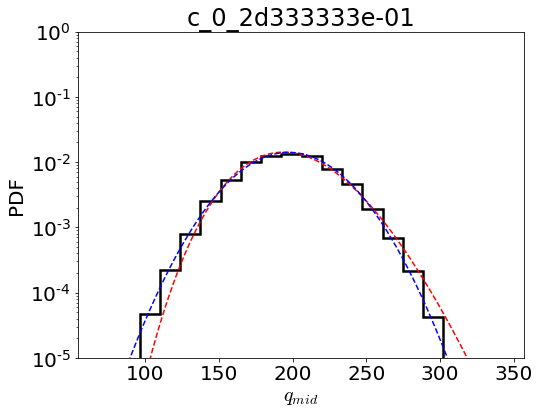

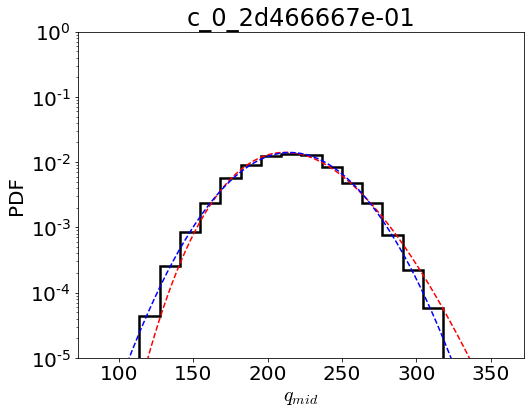

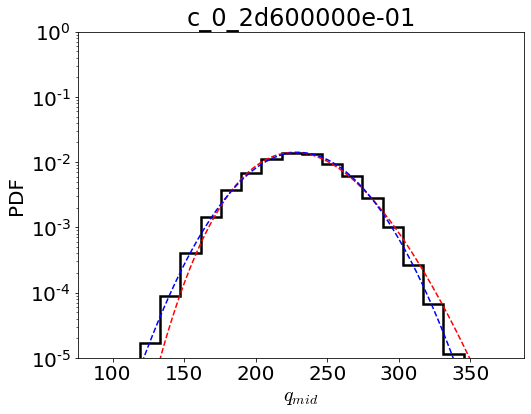

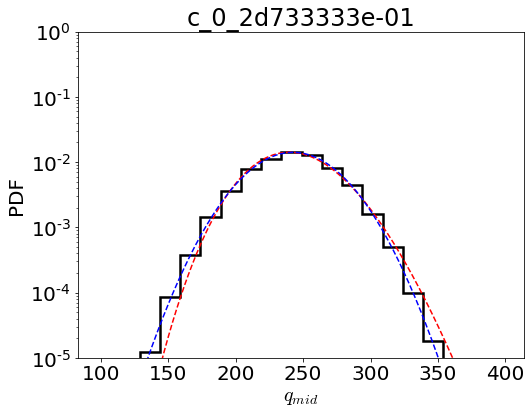

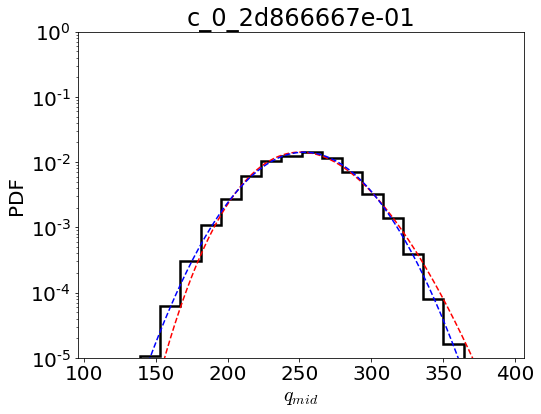

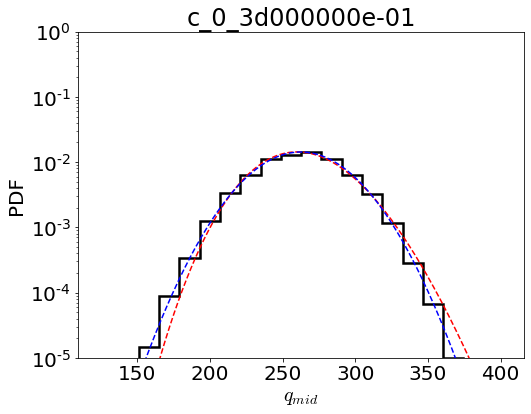

Working on ../256x256_f


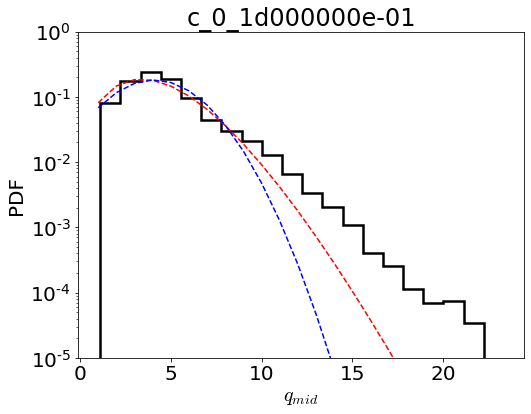

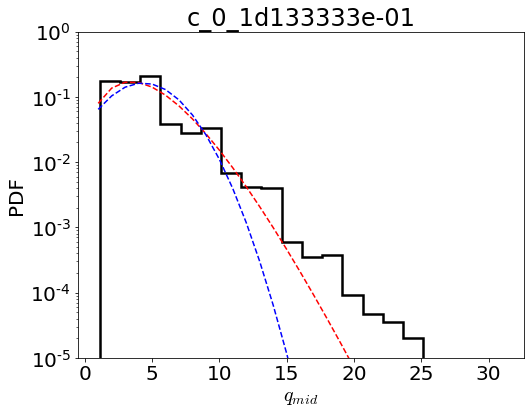

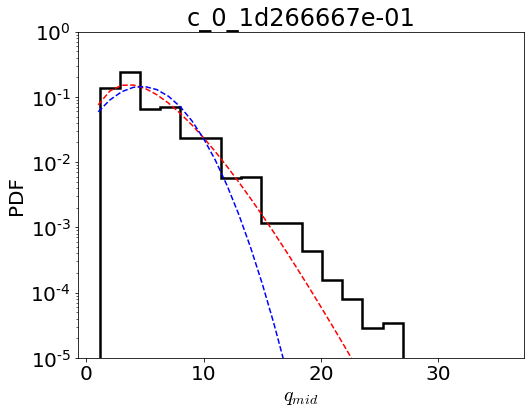

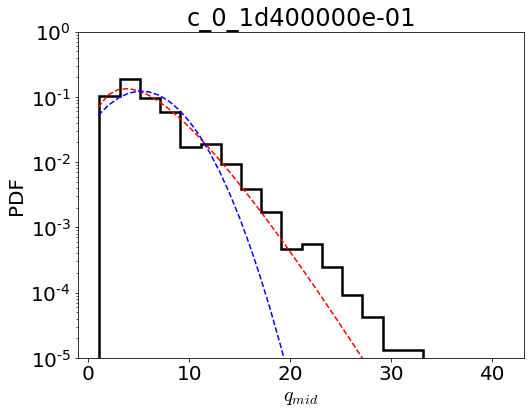

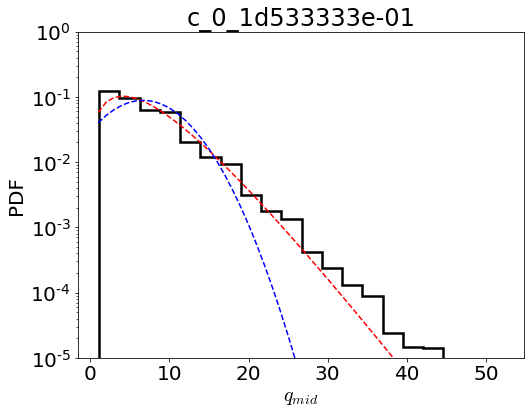

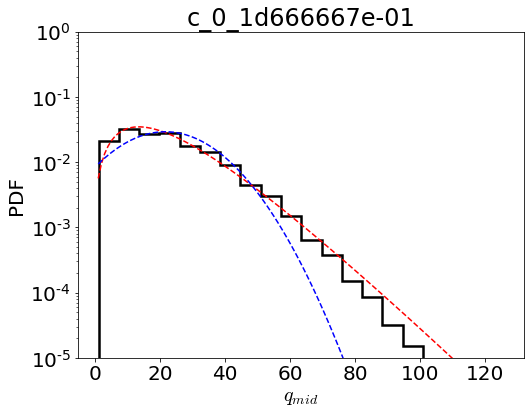

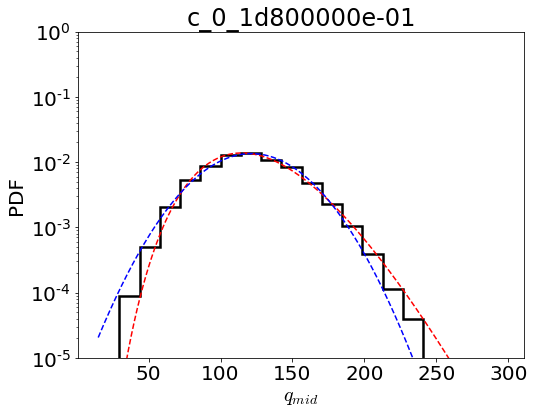

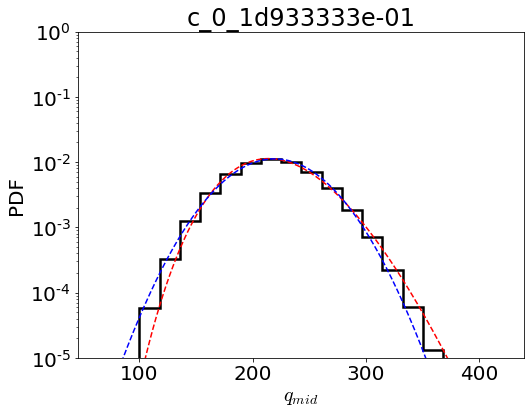

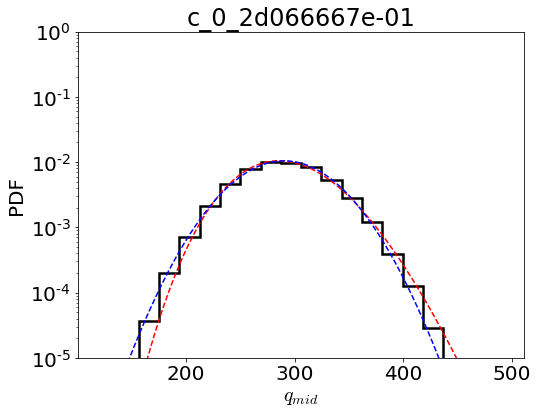

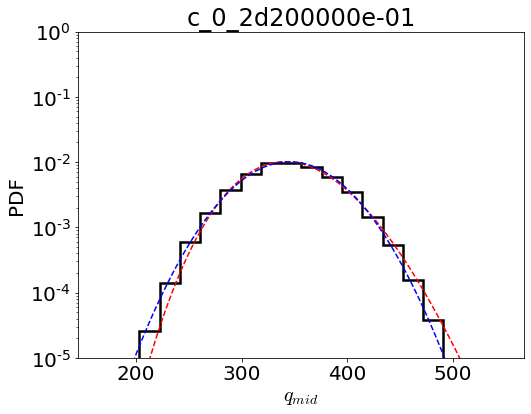

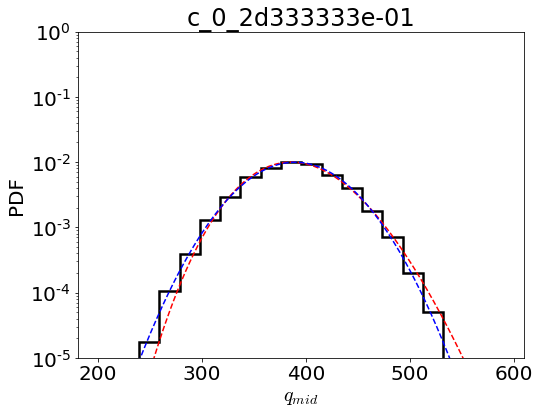

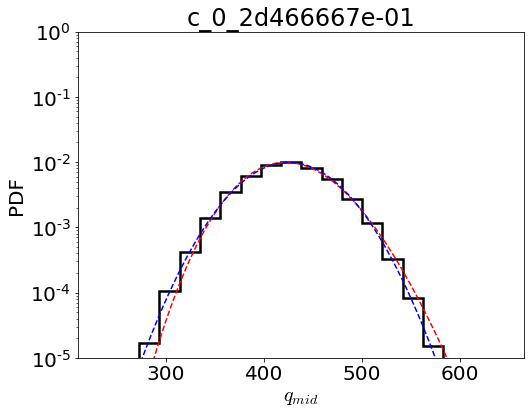

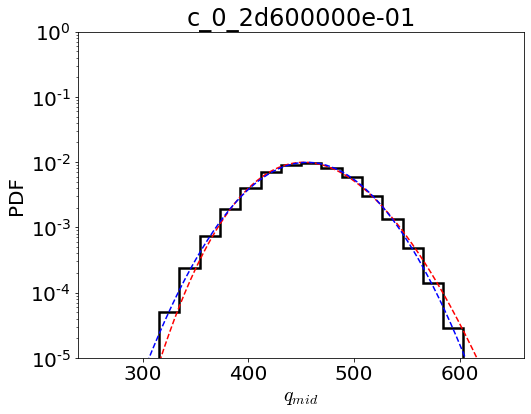

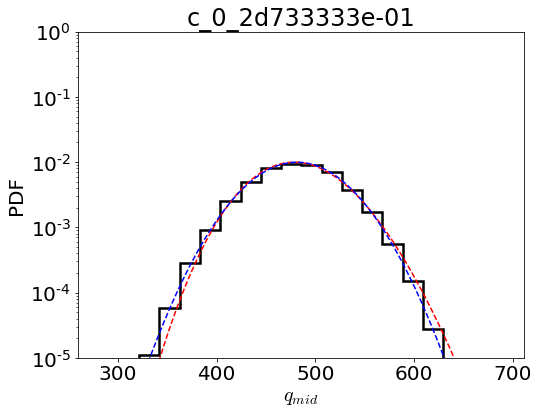

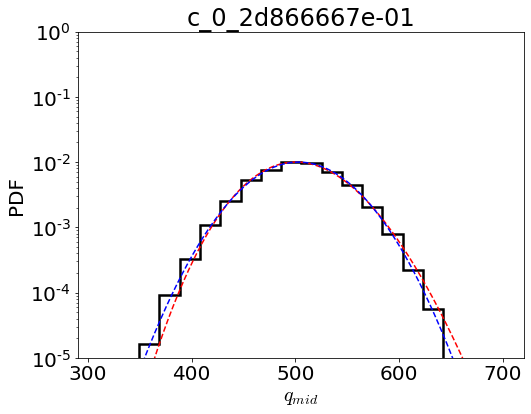

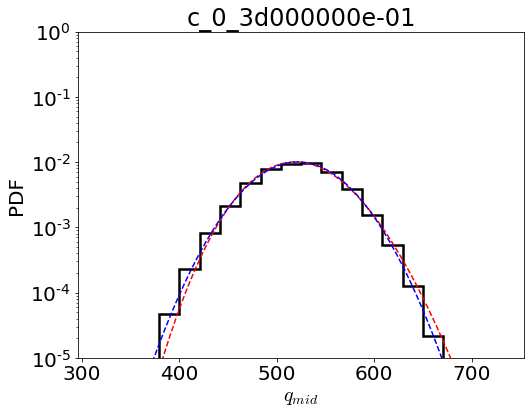

Working on ../512x512_f


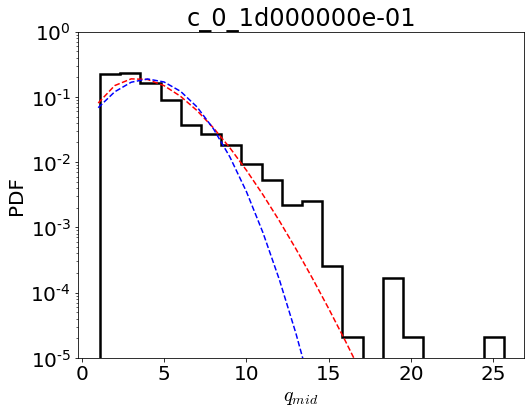

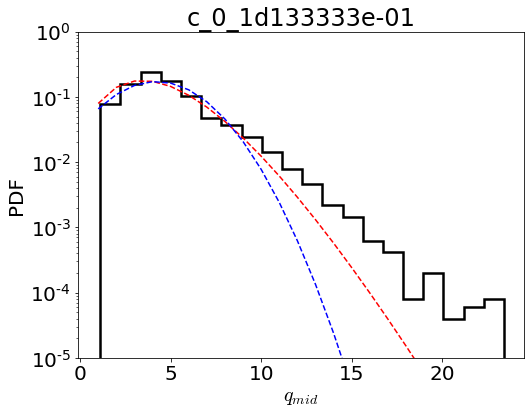

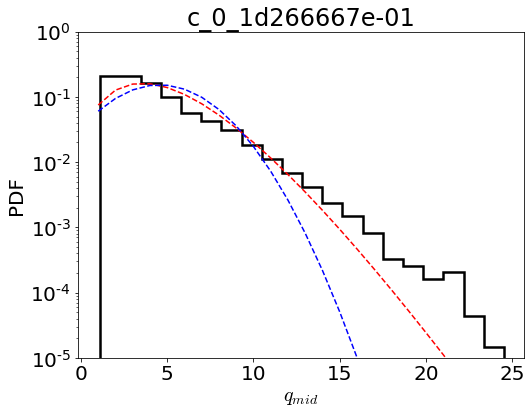

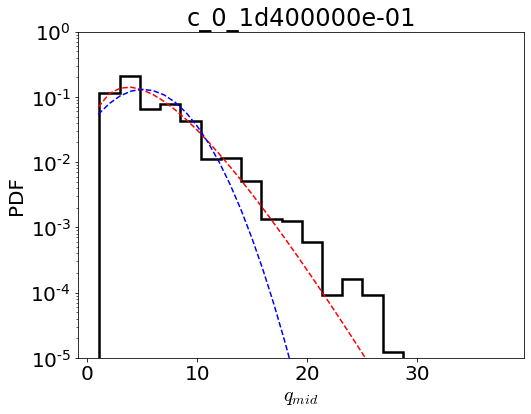

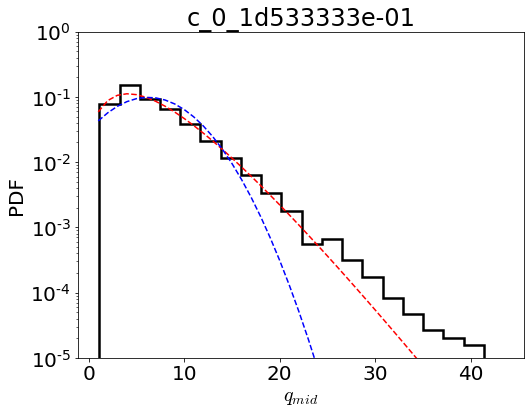

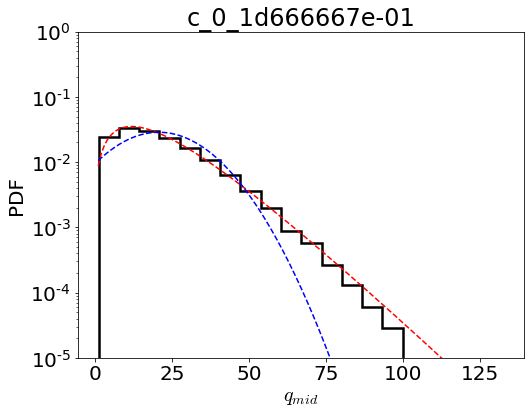

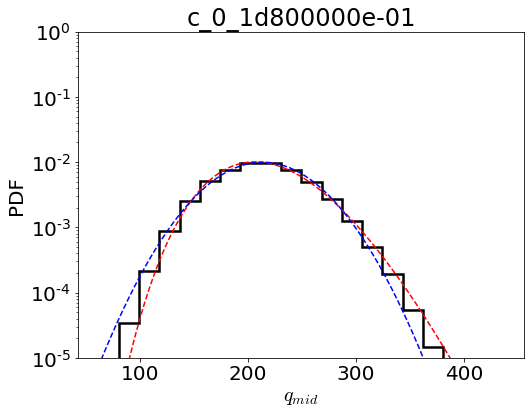

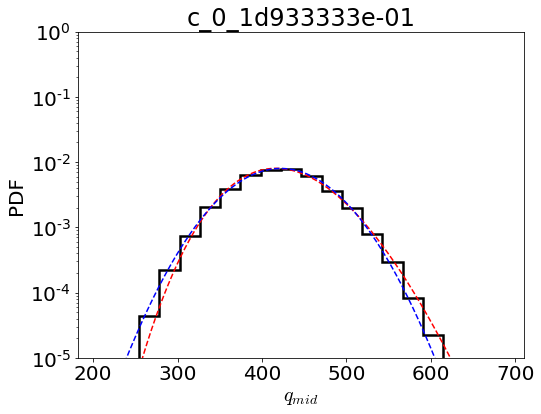

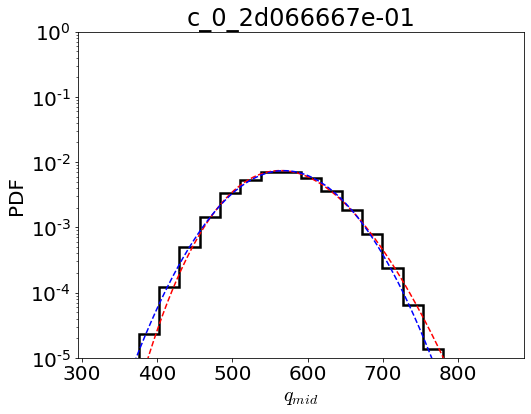

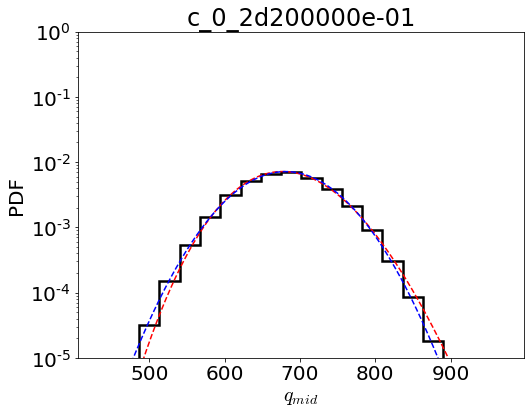

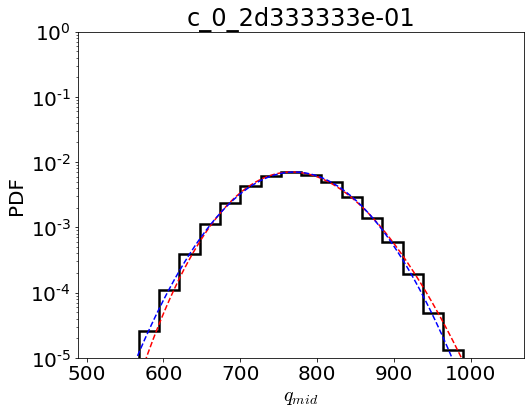

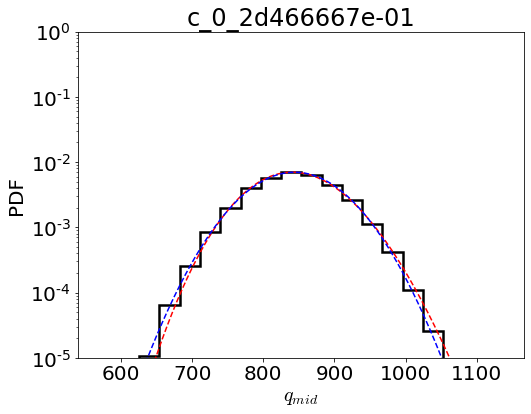

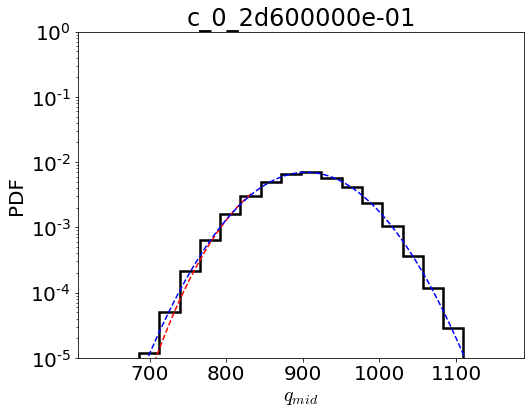

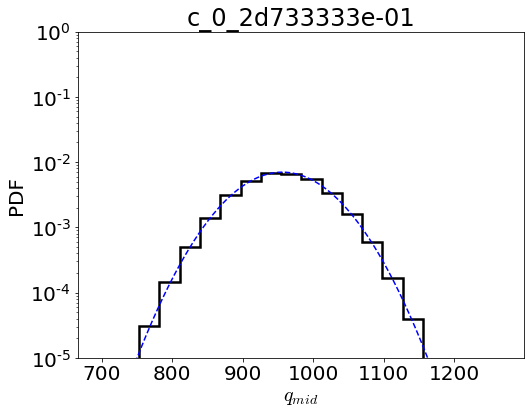

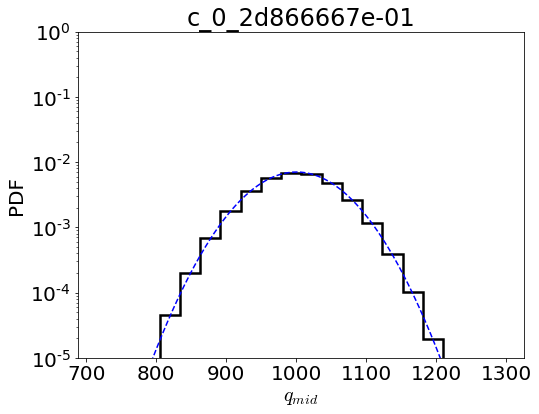

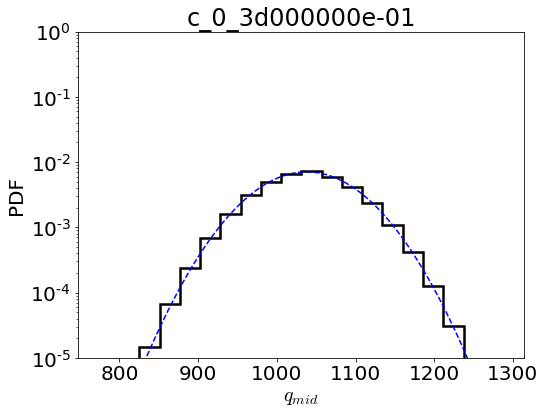

In [25]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plot_yn=False
for idir in idirs:
    print("Working on %s" % idir)
    ba_l = []
    qs_l = []
    c0s_l = []
    
#     dirs = sorted(glob.glob(idir+'/c_0*'))
    dirs = glob.glob(idir+'/*/*_scalars.h5')
    
    runs = []
    for file in dirs:
        run = file.split('/')[2]
        runs.append(run)

    # Sort run-names based on value of c_0
    runs = sorted(runs, key=lambda x: float(x.split('_')[2].replace('d','.')), reverse=False)

    for ii,run in enumerate(runs):
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        with h5py.File(fname,'r') as file:
            Nx = file['parameters']['Nx'][()]
            Ny = file['parameters']['Ny'][()]
            c_0 = file['parameters']['c_0'][()]
            f = file['parameters']['f'][()]
            u_p = file['parameters']['u_p'][()]
            skipmax = file['parameters']['skipmax'][()]    

            # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last']
            time = file['scalars']['time'][()]
    #         tstep = file['scalars']['tstep'][()]
            bed_activity = file['scalars']['bed_activity'][()]
            q = file['scalars']['q_mid'][()]

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q[q>0]

        plt.figure(figsize=(8,6))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = np.min(q),xmax = max(q), output='pdf')
#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-')#,c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
#         d = np.diff(np.unique(q)).min()
#         left_of_first_bin = q.min() - float(d)/2
#         right_of_last_bin = q.max() + float(d)/2
#         plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,color='k')#,
#                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)))#,label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
        plt.hist(q, histtype='step',bins=nbin,log=True,density=True,lw=2.5,color='k')#,
        
        xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
#         plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',color = 'r')#cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        plt.plot(xplt,GaussDist(xplt,np.mean(q),np.var(q)),'--',color = 'b')#cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        
        
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


#     slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
#     qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

# plt.ylim(0,0.35)
# plt.xlim(-5,5)
# plt.xlabel(r"$\left(e_{mid}-\langle e_{mid}\rangle\right) / \sqrt{\langle e_{mid} \rangle }$")

        # ax=plt.gca()
        # ax.set_yscale('log')
        # plt.xlabel(r"$q_{out}$")
        plt.ylim(1e-5,1)
#         plt.xlabel(r"$N_{mid}$")
        plt.xlabel(r"$q_{mid}$")
        plt.ylabel("PDF")
        plt.title(run)
#         plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000"+r" $q^*_{in} =$ %.3f" % (q8_in))
#         plt.legend(loc=(1.01,0.0))
        plt.show()
        plt.close()  

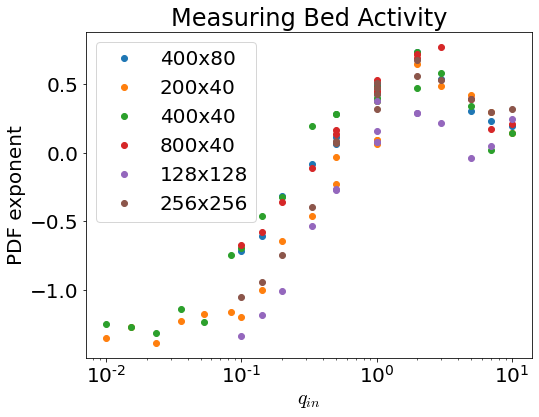

In [16]:
plt.figure(figsize=(8,6))
# plt.semilogx(q8_ins_ba,slopes_ba,'ok')
for dirr in slopes_ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
    plt.semilogx(qin_reals_ba[dirr],slopes_ba[dirr],marker = 'o',ls='',label = dirr)
plt.legend()
# plt.xlabel("$q^*_{in}$")
plt.xlabel("$q_{in}$")
plt.ylabel("PDF exponent")
plt.title("Measuring Bed Activity")
plt.show()

In [30]:
slopes_ba = dict([])
Nys = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(runs):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')


        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in/norm

#         q_mid = file['scalars']['q_out'][()]#*norm
        q_mid = file['scalars']['e_mid'][()]#*norm
        q_mid = q_mid[q_mid>0]
#         print(np.mean(q_mid)/np.var(q_mid))
        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid
#         q = (q-np.mean(q))/np.sqrt(np.mean(q))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 8,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/norm # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

# #         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.plot(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        
        plt.figure(figsize=(8,6))
    
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        pdf,edges,patches = plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,
                 color = cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f, %sx%s" % (q8_in,Nx,Ny),lw=2.5)
        edges = np.diff(edges)/2+edges[:-1]
        
        xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
#         plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',color = 'r')#cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
#         plt.plot(xplt,Poisson(xplt,np.mean(q)),'--',color = 'b')
#         print(np.mean(q))
        m,b= np.polyfit(edges[int(np.mean(q))+1:],np.log(pdf[int(np.mean(q))+1:]),1)
        print(m,b)
        plt.plot(xplt,np.exp(m*xplt+b),'--b',label = 'e-folding: %.3f' % m)
#         plt.plot(xplt,GaussDist(xplt,np.mean(q),np.var(q)),'-.',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        

        # ax=plt.gca()
        # ax.set_yscale('log')
        plt.ylim(1e-6,0.5)
        plt.xlabel(r"$e_{mid}$")
        plt.title(r"Varying $N_y$,"+r" $q^*_{in} =$ %.3f, %sx%s" % (q8_in,Nx,Ny))
        plt.ylabel("PDF")
        #         plt.legend(loc=(1.01,0.0))
        # plt.xlim(8,200)
        plt.legend()
        plt.show()
        plt.close()

Working on ../1024x1024_f
Working on ../128x128_f
Working on ../256x256_f
Working on ../512x512_f


<Figure size 576x432 with 0 Axes>

In [32]:
slopes_ba = dict([])
Nys = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(runs):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')


        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in/norm

#         q_mid = file['scalars']['q_out'][()]#*norm
        q_mid = file['scalars']['e_mid'][()]#*norm
        q_mid = q_mid[q_mid>0]
#         print(np.mean(q_mid)/np.var(q_mid))
        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20
        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['q_mid'][()][300:]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()
    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]
#         q = (q-np.mean(q))/np.sqrt(np.mean(q))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 3/norm,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/norm # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

        plt.figure(figsize=(8,6))

#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,
                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
        
        xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
#         plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',color = 'r')#cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        
        
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


#     slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
#     qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

# plt.ylim(0,0.35)
# plt.xlim(-5,5)
# plt.xlabel(r"$\left(e_{mid}-\langle e_{mid}\rangle\right) / \sqrt{\langle e_{mid} \rangle }$")

        # ax=plt.gca()
        # ax.set_yscale('log')
        # plt.xlabel(r"$q_{out}$")
        plt.ylim(1e-5,0.5)
        plt.xlabel(r"$N_{mid}$")
        plt.ylabel("PDF")
        plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000"+r" $q^*_{in} =$ %.3f" % (q8_in))
#         plt.legend(loc=(1.01,0.0))
        plt.show()
        plt.close()  

Working on ../1024x1024_f
Working on ../128x128_f
Working on ../256x256_f
Working on ../512x512_f


<Figure size 576x432 with 0 Axes>

## Waiting time PDF

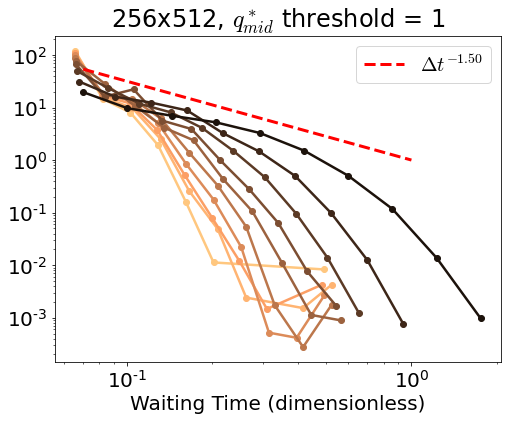

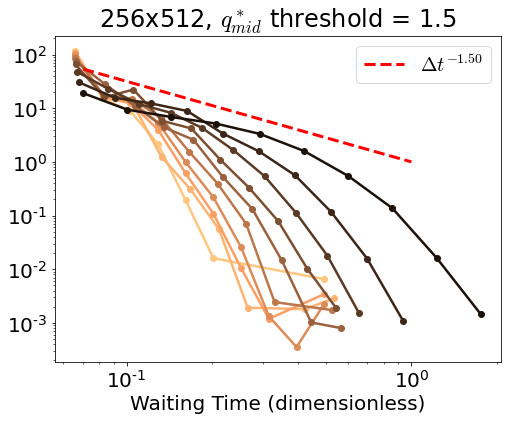

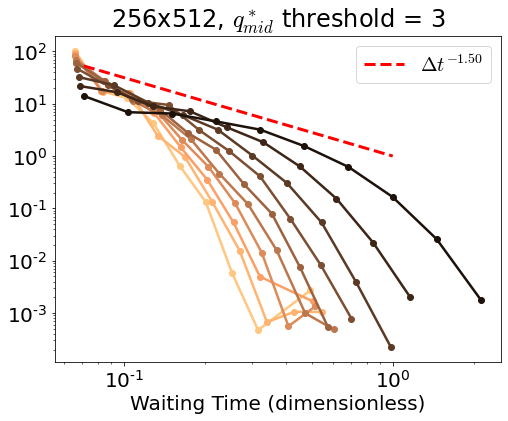

In [33]:
# Choose directory
# idir = '../200x40/'
Nx = 256
Ny = 512
idir = '../'+str(Nx)+'x'+str(Ny)+'/'
u_p = 1
skipmax=3
dx = 1/(Nx-1)

dt = skipmax*dx / u_p

exp_plot= [
    'q_1d000000e+00',
    'q_2d000000e+00',
    'q_3d000000e+00',
    'q_4d000000e+00',
    'q_5d000000e+00',
    'q_6d000000e+00',
    'q_7d000000e+00',
    'q_8d000000e+00',
    'q_9d000000e+00',
    'q_1d000000e+01',
]

for thresh in [
    1,
    1.5,
    3,
#     30,
#     40,
#     100,
]:
    qm = []
    qs = []
    slopes_wt = []
    q8_ins_wt = []

    mindat = 5*dt
    # maxdat = 1.0

    nbins = 10

    plt.figure(figsize=(8,6))

    for ii,run in enumerate(reversed(exp_plot)):
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
        q = file['scalars']['q_mid'][()] # So that it's number of grains * vel
        
        # Close file:
        file.close()

        ##############################

        # Choose data to plot:
        dat = onoff_dist(q,dt,thresh)
        hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
        x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
        y = hist
    #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

        # Plot
    #     plt.figure(figsize=(8,6))
        plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
                   color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),lw=2.5)
    #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
    #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

    #     plt.axvline(x=int(1/q_in),color = 'b')

    #     # Finite size effect cutoff
    #     nbeads = 2# Number of grains considered 'too small'
    #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
    #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

    #     # Fit
    #     fitmax = 2e-3
    #     fitmin = xcutoff 
    #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
    #     slopes_ba.append(m)
    #     q8_ins_ba.append(q8_in)

    m = -3/2.
    b = 1.
    xpl = np.logspace(np.min(x),np.log10(1),100)
    plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)

    plt.legend()#loc=(1.01,0.0))
    plt.title("%sx%s, $q^*_{mid}$ threshold = %s" % (Nx,Ny,thresh))
    plt.xlabel(r"Waiting Time (dimensionless)")
    # plt.xlabel(r"$q_{out}$")

    plt.show()
        
# slopes_ba = np.array(slopes_ba)
# q8_ins_ba = np.array(q8_ins_ba)

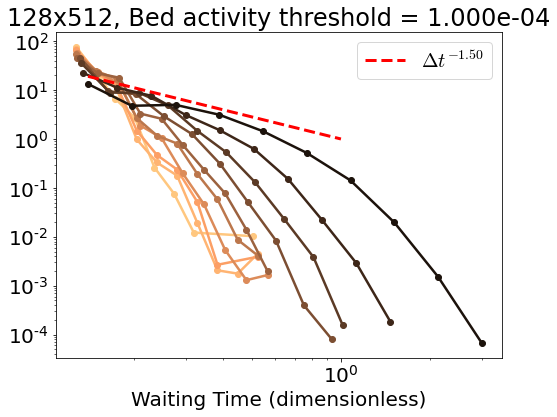

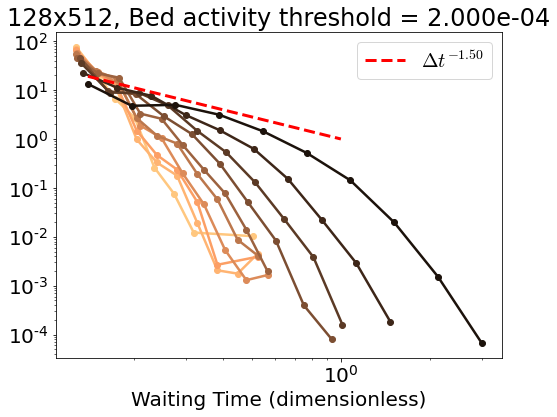

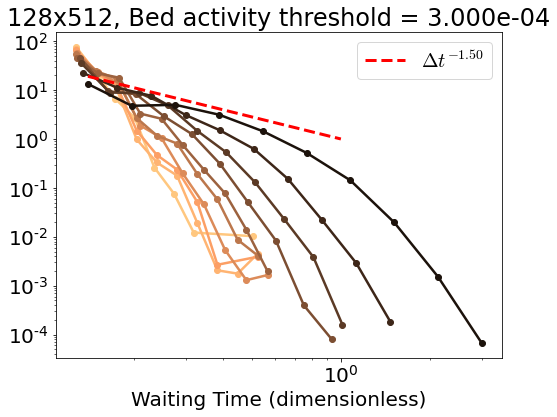

In [104]:
# Choose directory
# idir = '../200x40/'
Nx = 128
Ny = 512
idir = '../'+str(Nx)+'x'+str(Ny)+'/'
u_p = 1
skipmax=3
dx = 1/(Nx-1)

dt = skipmax*dx / u_p

exp_plot= [
    'q_1d000000e+00',
    'q_2d000000e+00',
    'q_3d000000e+00',
    'q_4d000000e+00',
    'q_5d000000e+00',
    'q_6d000000e+00',
    'q_7d000000e+00',
    'q_8d000000e+00',
    'q_9d000000e+00',
    'q_1d000000e+01',
]

for thresh in [
    1,
    2,
    3,
#     30,
#     40,
#     100,
]:
    qm = []
    qs = []
    slopes_wt = []
    q8_ins_wt = []

    mindat = 5*dt
    # maxdat = 1.0

    nbins = 10
    
    thresh = thresh*10**(-4)

    plt.figure(figsize=(8,6))

    for ii,run in enumerate(reversed(exp_plot)):
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
        q = file['scalars']['q_mid'][()] # So that it's number of grains * vel
        
        # Close file:
        file.close()

        ##############################

        # Choose data to plot:
        dat = onoff_dist(q,dt,thresh)
        hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
        x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
        y = hist
    #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

        # Plot
    #     plt.figure(figsize=(8,6))
        plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
                   color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),lw=2.5)
    #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
    #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

    #     plt.axvline(x=int(1/q_in),color = 'b')

    #     # Finite size effect cutoff
    #     nbeads = 2# Number of grains considered 'too small'
    #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
    #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

    #     # Fit
    #     fitmax = 2e-3
    #     fitmin = xcutoff 
    #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
    #     slopes_ba.append(m)
    #     q8_ins_ba.append(q8_in)

    m = -3/2.
    b = 1.
    xpl = np.logspace(np.min(x),np.log10(1),100)
    plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)

    plt.legend()#loc=(1.01,0.0))
    plt.title("%sx%s, Bed activity threshold = %.3e" % (Nx,Ny,thresh))
    plt.xlabel(r"Waiting Time (dimensionless)")
    # plt.xlabel(r"$q_{out}$")

    plt.show()
        
# slopes_ba = np.array(slopes_ba)
# q8_ins_ba = np.array(q8_ins_ba)

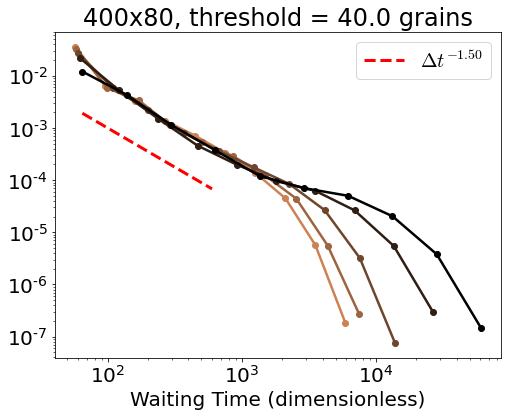

In [38]:
# Choose directory
idir = '../400x80/'
Nx = 400
Ny = 80

exp_plot= [
#     'q_1d000000e-02', # These don't exist yet
#     'q_1d513561e-02', # These don't exist yet
#     'q_2d290868e-02', # These don't exist yet
#     'q_3d467369e-02', # These don't exist yet
#     'q_5d248075e-02', # These don't exist yet
#     'q_7d943282e-02', # These don't exist yet
    'q_1d000000e-01', 
#     'q_1d359356e-01', 
    'q_1d847850e-01', 
#     'q_2d511886e-01', 
    'q_3d414549e-01', 
#     'q_4d641589e-01', 
    'q_6d309573e-01', 
#     'q_8d576959e-01', 
#     'q_1d165914e+00', 
#     'q_1d584893e+00', 
    'q_2d154435e+00', 
#     'q_2d928645e+00', 
#     'q_3d981072e+00', 
#     'q_5d411695e+00', 
#     'q_7d356423e+00', 
#     'q_1d000000e+01',
]

for thresh in [
#     10,
#     20,
    40,
#     80,
]:
    qm = []
    qs = []
    slopes_wt = []
    q8_ins_wt = []

    dt_min = 5e-3
    dt_max = 5
    pdf_min = 1e-3
    pdf_max = 5e2

    dt = 22.139999985694885 # Simulation parameter

    mindat = 2*dt
    # maxdat = 1.0

    nbins = 10

    thresh = thresh/(Nx*Ny)#20/(Nx*Ny)#10/(Nx*Ny)#9e-4 # Chosen by looking at PDFs, getting into the tail.

    plt.figure(figsize=(8,6))

    for ii,run in enumerate(reversed(exp_plot)):
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        rho = 0.8
        dt = file['parameters']['dt'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
        q8_in = norm*q_in_real

        # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
        time = file['scalars']['time'][()]
        tstep = file['scalars']['tstep'][()]
        q_out = file['scalars']['q_out'][()]
        q8_out = q_out*norm
        bed_activity = file['scalars']['bed_activity'][()]

        # Close file:
        file.close()

        ##############################

        # Choose data to plot:
        dt = np.diff(time)[0]
        dat = onoff_dist(bed_activity,dt,thresh)
        hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
        x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
        y = hist
    #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

        # Plot
    #     plt.figure(figsize=(8,6))
        plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
                   color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),lw=2.5)
    #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
    #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

    #     plt.axvline(x=int(1/q_in),color = 'b')

    #     # Finite size effect cutoff
    #     nbeads = 2# Number of grains considered 'too small'
    #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
    #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

    #     # Fit
    #     fitmax = 2e-3
    #     fitmin = xcutoff 
    #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
    #     slopes_ba.append(m)
    #     q8_ins_ba.append(q8_in)

    m = -3/2.
    b = 1.
    xpl = np.logspace(np.min(x),np.log10(600),100)
    plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)

    plt.legend()#loc=(1.01,0.0))
    plt.title("%sx%s, threshold = %s grains" % (Nx,Ny,thresh*Nx*Ny))
    plt.xlabel(r"Waiting Time (dimensionless)")
    # plt.xlabel(r"$q_{out}$")

    plt.show()
        
# slopes_ba = np.array(slopes_ba)
# q8_ins_ba = np.array(q8_ins_ba)

In [23]:
# # Choose directory
# idir = '../400x80/'
# Nx = 400
# Ny = 80

# exp_plot= [
# #     'q_1d000000e-02',  #
# #     'q_1d513561e-02',  #
# #     'q_2d290868e-02',  # These runs don't exist yet
# #     'q_3d467369e-02',  # 
# #     'q_5d248075e-02',  #
# #     'q_7d943282e-02',  #
#     'q_1d000000e-01', 
# #     'q_1d359356e-01', 
#     'q_1d847850e-01', 
# #     'q_2d511886e-01', 
#     'q_3d414549e-01', 
# #     'q_4d641589e-01', 
#     'q_6d309573e-01', 
# #     'q_8d576959e-01', 
# #     'q_1d165914e+00', 
# #     'q_1d584893e+00', 
#     'q_2d154435e+00', 
# #     'q_2d928645e+00', 
# #     'q_3d981072e+00', 
# #     'q_5d411695e+00', 
# #     'q_7d356423e+00', 
# #     'q_1d000000e+01',
# ]

# qm = []
# qs = []
# slopes_wt = []
# q8_ins_wt = []

# dt_min = 5e-3
# dt_max = 5
# pdf_min = 1e-3
# pdf_max = 5e2

# dt = 22.139999985694885 # Simulation parameter

# mindat = 2*dt
# # maxdat = 1.0

# nbin = 15

# thresh = 10/(Nx*Ny)#9e-4 # Chosen by looking at PDFs, getting into the tail.

# plt.figure(figsize=(8,6))

# for ii,run in enumerate(exp_plot):
#     # Open 
#     fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
#     file = h5py.File(fname,'r')
    
#     # Get parameters:
#     Nx = file['parameters']['Nx'][()]
#     Ny = file['parameters']['Ny'][()]
#     c_0 = file['parameters']['c_0'][()]
#     f = file['parameters']['f'][()]
#     q_in = file['parameters']['q_in'][()]
#     skipmax = file['parameters']['skipmax'][()]
#     rho = 0.8
#     dt = file['parameters']['dt'][()]
#     if q_in<1:
#         q_in_real = 1/int(1/q_in)
# #         print("q_in real",q_in_real)
#     else:
#         q_in_real = int(q_in)
# #         print("q_in > 1",int(q_in))
    
#     # Normalize
#     norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
#     q8_in = norm*q_in_real
    
#     # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
#     time = file['scalars']['time'][()]
#     tstep = file['scalars']['tstep'][()]
#     q_out = file['scalars']['q_out'][()]
#     q8_out = q_out*norm
#     bed_activity = file['scalars']['bed_activity'][()]
    
#     # Close file:
#     file.close()

#     ##############################

#     # Choose data to plot:
#     dt = np.diff(time)[0]
#     dat = onoff_dist(bed_activity,dt,thresh)
#     hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
#     x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
#     y = hist
# #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

#     # Plot
# #     plt.figure(figsize=(8,6))
#     plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
#                color=cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),lw=2.5)
# #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
# #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

# #     # Finite size effect cutoff
# #     nbeads = 2# Number of grains considered 'too small'
# #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
# #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
# #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

# #     # Fit
# #     fitmax = 2e-3
# #     fitmin = xcutoff 
# #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
# #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #     slopes_ba.append(m)
# #     q8_ins_ba.append(q8_in)

# m = -3/2.
# b = 1.
# xpl = np.logspace(np.min(x),np.log10(600),100)
# plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)


# plt.title("%sx%s, threshold = %s grains" % (Nx,Ny,thresh*Nx*Ny))
# plt.legend()#loc=(1.01,0.0))
# plt.xlabel(r"Waiting Time (dimensionless)")
# # plt.xlabel(r"$q_{out}$")

# plt.show()
        
# # slopes_ba = np.array(slopes_ba)
# # q8_ins_ba = np.array(q8_ins_ba)

## Random plots 

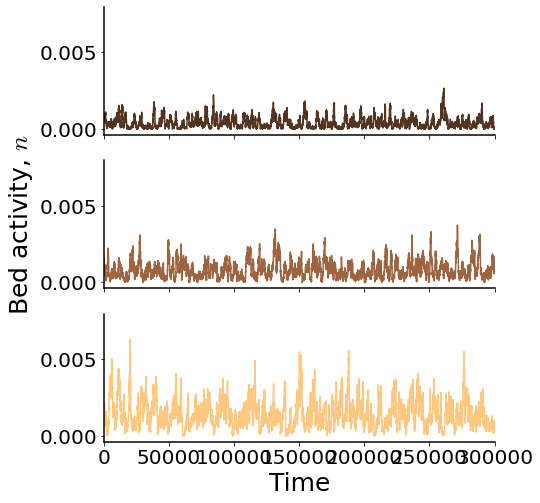

In [28]:
# Choose directory
idir = '../256x256/'
Nx = 256
Ny = 256

exp_plot = [
#     'q_1d000000e-01', ##
#     'q_1d359356e-01', 
#     'q_1d847850e-01', 
    'q_2d511886e-01', ##
#     'q_3d414549e-01', 
#     'q_4d641589e-01', 
#     'q_6d309573e-01', ##
    'q_8d576959e-01', 
#     'q_1d165914e+00', 
#     'q_1d584893e+00', 
#     'q_2d154435e+00', 
#     'q_2d928645e+00', 
#     'q_3d981072e+00', 
#     'q_5d411695e+00', 
#     'q_7d356423e+00', 
    'q_1d000000e+01',
]

nbin = 15
multf = 100
yint = 0.0

fig,ax = plt.subplots(3,1,figsize=(7,8),sharex='col',sharey='col')

for ii,run in enumerate(exp_plot):

    #####################
    #### TIME SERIES ####
    #####################
    for spine in ax[ii].spines.items():
        ax[ii].spines[spine[0]].set_linewidth(1.5)
    ax[ii].spines['right'].set_linewidth(0)
    ax[ii].spines['top'].set_linewidth(0)
    if ii==1:
#         ax[ii].set_ylabel(r"Sediment flux, $q^*$",fontsize=25)
        ax[ii].set_ylabel(r"Bed activity, $n$",fontsize=25)
    if ii==2:
        ax[ii].set_xlabel(r"Time",fontsize=25)
        #     plt.tight_layout()

        # Open 
    fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    
    # Get parameters:
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    skipmax = file['parameters']['skipmax'][()]
    rho = 0.8
    dt = file['parameters']['dt'][()]
    if q_in<1:
        q_in_real = 1/int(1/q_in)
#         print("q_in real",q_in_real)
    else:
        q_in_real = int(q_in)
#         print("q_in > 1",int(q_in))
    
    # Normalize
    norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
    q8_in = norm*q_in_real
    
    # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
    t = file['scalars']['time'][()]
    tstep = file['scalars']['tstep'][()]
    q_out = file['scalars']['q_out'][()]
    q8_out = q_out*norm
    q = file['scalars']['bed_activity'][()]
    
    # Close file:
    file.close()
    
    ### TIME SERIES
    ax[ii].plot(t-t[0],q,color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),label = r'$\langle q^*_{in} \rangle = $ %.3e' % q8_in)
#     tshift= t[0]
    deltat = 100000 #500000
    ax[ii].set_xlim(0,3*deltat)
#     ax[ii].set_ylim(0,0.02)
#     if ii==0:
#         ax[ii].legend(title="Input flux",loc=1)
#     else:
#         ax[ii].legend(loc=1)

###########################
# plt.savefig(odir+"Fig2_1_SIM.png",bbox_inches= "tight",dpi=300)

plt.show()

<ipython-input-26-1ff231595ef7>:103: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fff9bd30340> has a label of '_line3' which cannot be automatically added to the legend.
  first_legend = pdf_ax.legend(handles=tslope,frameon=False,loc=1,fontsize=25)


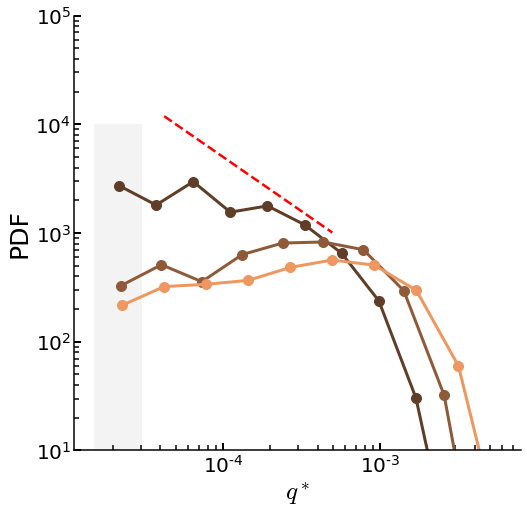

In [26]:
# Choose directory
idir = '../256x256/'
Nx = 256
Ny = 256

exp_plot = [
#     'q_1d000000e-01', ##
#     'q_1d359356e-01', 
#     'q_1d847850e-01', 
    'q_2d511886e-01', ##
#     'q_3d414549e-01', 
#     'q_4d641589e-01', 
#     'q_6d309573e-01', ##
    'q_8d576959e-01', 
#     'q_1d165914e+00', 
#     'q_1d584893e+00', 
#     'q_2d154435e+00', 
#     'q_2d928645e+00', 
#     'q_3d981072e+00', 
#     'q_5d411695e+00', 
#     'q_7d356423e+00', 
    'q_1d000000e+01',
]

nbin = 10
multf = 1
yint = 0.0


# Finite size effect cutoff
nbeads = 2# Number of grains considered 'too small'
xcutoff = nbeads/(Nx*Ny) # Five grains active total

# fig,(ax) = plt.subplots(1,1,figsize=(12,8))
fig, pdf_ax = plt.subplots(1,1,figsize=(8,8))
for ii,run in enumerate(exp_plot):
    # Open 
    fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    
    # Get parameters:
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    skipmax = file['parameters']['skipmax'][()]
    rho = 0.8
    dt = file['parameters']['dt'][()]
    if q_in<1:
        q_in_real = 1/int(1/q_in)
#         print("q_in real",q_in_real)
    else:
        q_in_real = int(q_in)
#         print("q_in > 1",int(q_in))
    
    # Normalize
    norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
    q8_in = norm*q_in_real
    
    # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
    t = file['scalars']['time'][()]
    tstep = file['scalars']['tstep'][()]
    q_out = file['scalars']['q_out'][()]
    q8_out = q_out*norm
    q = file['scalars']['bed_activity'][()]
    
    # Close file:
    file.close()
    
    pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin, output='pdf')#,xmin = xcutoff,xmax = max(q), output='pdf')
    plt.loglog(x[pdf>0],pdf[pdf>0],marker='o',lw=3,ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

#     plt.axvline(x= xcutoff,color='b')

    xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
#     if run=='q_6d309573e-01':
#         # For plotting example gaussian
#         x = np.logspace(np.log10(2e-3),np.log10(max(q)),1000)
#         mean = np.nanmean(q)
#         std = np.nanstd(q)
#         gauss = pdf_ax.loglog(x,(1/(std*np.sqrt(2*np.pi)))*np.exp(-0.5*(x-mean)**2/std**2),ls = '--',c='grey',zorder=-10,lw=2.5,label="Gaussian")
    

# pdf_ax.set_ylim(1e-1,1e4)
pdf_ax.set_ylim(1e1,1e5)
# pdf_ax.set_xlim(2e-3,3)
pdf_ax.tick_params(axis='both',which = 'both',direction='in')#,width=2)
for spine in pdf_ax.spines.items():
    pdf_ax.spines[spine[0]].set_linewidth(1.5)
pdf_ax.spines['right'].set_linewidth(0)
pdf_ax.spines['top'].set_linewidth(0)
pdf_ax.tick_params(width=2,length=7,which='major')
pdf_ax.tick_params(width=1.5,length=5,which='minor')
pdf_ax.set_ylabel(r"PDF",fontsize=25)
pdf_ax.set_xlabel(r"$q^*$",fontsize=25)
# plt.text(2.5e-3,8e1, "g",fontsize=25)

yexp = -1.
tslope = pdf_ax.loglog(x[(xcutoff<x)&(x<9e-4)], 10**(-0.3)*x[(xcutoff<x)&(x<9e-4)]**(yexp),ls='--',color='r',lw=2.5)#,
#               label = 'Theoretical \n PDF exponent \n at threshold \n of motion',lw=2.5)
first_legend = pdf_ax.legend(handles=tslope,frameon=False,loc=1,fontsize=25)
pdf_ax.add_artist(first_legend)
# pdf_ax.legend(handles=gauss,frameon=False,loc=3,fontsize=25)

###########################
# plt.savefig(odir+"Fig2_2.png",bbox_inches= "tight",dpi=300)

plt.show()